In [1]:
import os
import glob
from torch_snippets import *
from torch_snippets import Glob, stem, show, read
from PIL import Image
import pandas as pd
import torch
import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
IMAGE_ROOT = '../../kaggle_data/images_bus_trucks/images/images/'

DF_RAW = df_init_labels = pd.read_csv('../../kaggle_data/images_bus_trucks/df.csv')
print("----",DF_RAW.head())

----             ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875 

In [7]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
print("-label2target---\n",label2target)
label2target['background'] = 0 ## add a key to DICT -- named background -- VALUE == 0 
print("-label2target---\n",label2target)

target2label = {t:l for l,t in label2target.items()}
print("-target2label---\n",target2label) ## Reverse DICT -- VALS are now KEYS --- and KEYS are VALS 
background_class = label2target['background']
num_classes = len(label2target)
#
def preprocess_image(img):
    """ display each PyTorch-Tensor [IMAGE] as an image """
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()
#

-label2target---
 {'Bus': 1, 'Truck': 2}
-label2target---
 {'Bus': 1, 'Truck': 2, 'background': 0}
-target2label---
 {1: 'Bus', 2: 'Truck', 0: 'background'}


In [8]:
# 
class OpenDataset(torch.utils.data.Dataset):
    """
    Source Official Tute PyTorch --> _book_4/mask_rcnn_official_PytorchExample/torchvision_finetuning_instance_segmentation.py
    See the DocString for ==> # Defining the Dataset
    
    1/ The reference scripts for training object detection, 
    instance segmentation and 
    person keypoint detection -- allows for easily supporting adding new custom datasets. 
    
    2/ The dataset should inherit from the standard torch.utils.data.Dataset class, and implement 
    METHOD ==>> __len__ 
    and 
    METHOD ==>> __getitem__.
    
    3/ As has been done below in the book code for their Custom dataSet 

    4/ Additionally, if you want to use aspect ratio grouping during training 
    (so that each batch only contains images with similar aspect ratios), 
    then it is recommended to also implement a get_height_and_width method, 
    which returns the height and the width of the image. 
    If this method is not provided, we query all elements of the dataset via __getitem__ , 
    which loads the image in memory and is slower than if a custom method is provided
    """

    w, h = 224, 224
    def __init__(self, df_init_labels, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df_init_labels
        self.image_infos = df_init_labels.ImageID.unique()
    #
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix] ## FOOBAR -- ix is ID ?? 
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        
        #print("---__getitem__----df_init_labels.head()-----",df_init_labels.head())

        data = df_init_labels[df_init_labels['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist() # Convert Pandas Series Values to List 
        data = data[['XMin','YMin','XMax','YMax']].values

        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        print("----foobar----len(boxes",len(boxes))

        # torch Fast_RCNN expects ground truths as a dictionary of tensors
        ## FOOBAR -- See here for details of the STRUCTURE of the DICT ==> target 
        ## https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        print("--------target--",target) #list(target.keys())

        img = preprocess_image(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)



In [9]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

trn_ids, val_ids = train_test_split(df_init_labels.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df_init_labels[df_init_labels['ImageID'].isin(trn_ids)], df_init_labels[df_init_labels['ImageID'].isin(val_ids)] ## Slicing DF with Indexing 
print("----len(trn_df)----",len(trn_df))
print("----len(val_df)----",len(val_df))


----len(trn_df)---- 21598
----len(val_df)---- 2464


In [11]:

train_ds = OpenDataset(trn_df)
print("----type(train_ds)----",type(train_ds))
test_ds = OpenDataset(val_df)
#
low_batch_size=1 ## Original Book Code == 4

train_loader = DataLoader(train_ds, batch_size=low_batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
print("----type(train_loader)----",type(train_loader)) 
#  <class 'torch.utils.data.dataloader.DataLoader'>
test_loader = DataLoader(test_ds, batch_size=low_batch_size, collate_fn=test_ds.collate_fn, drop_last=True)
#


----type(train_ds)---- <class '__main__.OpenDataset'>
----type(train_loader)---- <class 'torch.utils.data.dataloader.DataLoader'>


In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
    ## # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print("----get_model---",model)
    return model




In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_fasterrcnn_resnet50 = get_model().to(device)

----get_model--- FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
      

In [14]:

# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train() # model_fasterrcnn_resnet50
    input, targets = inputs
    
    print("--train_batch--type(input----",type(input))

    input = list(image.to(device) for image in input)
    print("--train_batch--len(input----",len(input))
    #
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    #
    optimizer.zero_grad()
    #
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    #
    optimizer.step()
    return loss, losses


In [16]:
@torch.no_grad() # decorator method -
#this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. 
    # Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses


In [15]:
from torch_snippets import Report
#model = get_model().to(device) ## Done above -- again doing below 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_fasterrcnn_resnet50 = get_model().to(device)


# FOOBAR Test---1 
#optimizer = torch.optim.SGD(model_fasterrcnn_resnet50.parameters(), lr=0.5)#,momentum=0.9, weight_decay=0.0005)

#Book Code --->> 
optimizer = torch.optim.SGD(model_fasterrcnn_resnet50.parameters(), lr=0.005,momentum=0.9, weight_decay=0.0005)
#print("----type(optimizer--aaaa---",type(optimizer)) ## FOOBAR -- this prints only Once 
## code dies somewhere after 1 EPOCH in the For Loop below -- >> for epoch in range(n_epochs):



----get_model--- FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
      

In [17]:
n_epochs = 1 #5
log = Report(n_epochs)
#print("--log--",log) ##<torch_snippets.torch_loader.Report object at 0x7f33132f2eb0>
#
try:
    for epoch in range(n_epochs):
        print("----epoch__now---",epoch)
        len_train_loader  = len(train_loader) ## Book code == _n
        for ix, inputs in enumerate(train_loader): ## train_loader-->>  <class 'torch.utils.data.dataloader.DataLoader'>
            # print("----train_loader--->>-- type(inputs",type(inputs)) # tuple
            # print("----train_loader--->>-- inputs...\n",inputs) ## See own Log File >> /_book_4/logging_get_kaggle_data_5.log
            # print("----train_loader--->>-- inputs[0]...\n",inputs[0]) ## See own Log File >> /_book_4/logging_get_kaggle_data_5.log
            # print("----train_loader--->>-- inputs[1]...\n",inputs[1]) ## See own Log File >> /_book_4/logging_get_kaggle_data_5.log
            
            #print("----train_loader--->>-- inputs[2]...\n",inputs[2]) ## See own Log File >> /_book_4/logging_get_kaggle_data_5.log
            ### IndexError: tuple index out of range

            #if type(optimizer) optimizer = optimizer.zero_grad() ##TODO - ownExpCode_MemmoryIssues

            #optimizer = optimizer.zero_grad() ##TODO - ownExpCode_MemmoryIssues
            
            #print("-----------type(optimizer----bbb----",type(optimizer))

            loss, losses = train_batch(inputs, model_fasterrcnn_resnet50, optimizer)

            #print("-----------type(optimizer----cccc----",type(optimizer))

            loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
            pos = (epoch + (ix+1)/len_train_loader) ## Book code == _n
            log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                    trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                    trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

        if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)
except Exception as err_1:
    print("--Exception--err_1-----\n",err_1)
    pass     



----epoch__now--- 0
----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 77.,  34., 203., 145.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.000	trn_loss: 1.593	trn_loc_loss: 1.374	trn_regr_loss: 0.128	trn_objectness_loss: 0.084	trn_rpn_box_reg_loss: 0.006	(1.41s - 19306.21s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 61.,  31., 156.,  97.],
        [157.,  45., 223.,  91.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.000	trn_loss: 1.119	trn_loc_loss: 0.697	trn_regr_loss: 0.383	trn_objectness_loss: 0.035	trn_rpn_box_reg_loss: 0.003	(1.86s - 12768.14s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,  60.,  83., 157.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.000	trn_loss: 0.349	trn_loc_loss: 0.211	trn_regr_loss: 0.10

EPOCH: 0.002	trn_loss: 0.612	trn_loc_loss: 0.233	trn_regr_loss: 0.348	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.006	(11.40s - 6781.84s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 33.,  61., 180., 163.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.002	trn_loss: 0.231	trn_loc_loss: 0.102	trn_regr_loss: 0.101	trn_objectness_loss: 0.027	trn_rpn_box_reg_loss: 0.001	(11.85s - 6754.57s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 60.,  21., 187., 185.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.002	trn_loss: 0.320	trn_loc_loss: 0.148	trn_regr_loss: 0.149	trn_objectness_loss: 0.022	trn_rpn_box_reg_loss: 0.002	(12.30s - 6727.36s remaining)----foobar----len(boxes 6
--------target-- {'boxes': tensor([[ 20.,  81.,  63., 134.],
        [ 27.,  91., 200., 173.],
        [ 60.,  54., 111.,  82.],
     

EPOCH: 0.003	trn_loss: 0.133	trn_loc_loss: 0.047	trn_regr_loss: 0.080	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.002	(21.50s - 6383.84s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  30., 223., 169.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.003	trn_loss: 0.181	trn_loc_loss: 0.044	trn_regr_loss: 0.095	trn_objectness_loss: 0.038	trn_rpn_box_reg_loss: 0.004	(21.93s - 6371.72s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 31., 119.,  36., 128.],
        [ 57.,  69., 153., 170.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.004	trn_loss: 0.391	trn_loc_loss: 0.107	trn_regr_loss: 0.149	trn_objectness_loss: 0.099	trn_rpn_box_reg_loss: 0.036	(22.40s - 6370.71s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 67.,  59., 164., 179.],
        [128.,  29., 223., 221.]]), 

EPOCH: 0.005	trn_loss: 0.192	trn_loc_loss: 0.054	trn_regr_loss: 0.117	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.009	(31.64s - 6250.96s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 132., 212.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.005	trn_loss: 0.179	trn_loc_loss: 0.045	trn_regr_loss: 0.088	trn_objectness_loss: 0.043	trn_rpn_box_reg_loss: 0.002	(32.06s - 6243.95s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 11.,   0., 221., 222.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.005	trn_loss: 0.180	trn_loc_loss: 0.048	trn_regr_loss: 0.063	trn_objectness_loss: 0.051	trn_rpn_box_reg_loss: 0.018	(32.51s - 6241.49s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  6.,  35., 223., 156.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--

EPOCH: 0.007	trn_loss: 0.208	trn_loc_loss: 0.086	trn_regr_loss: 0.108	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.002	(41.67s - 6164.13s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 69.,  57., 173., 162.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.007	trn_loss: 0.334	trn_loc_loss: 0.131	trn_regr_loss: 0.165	trn_objectness_loss: 0.014	trn_rpn_box_reg_loss: 0.024	(42.11s - 6161.79s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 29.,  23., 208., 196.],
        [169.,  93., 201., 104.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.007	trn_loss: 0.255	trn_loc_loss: 0.080	trn_regr_loss: 0.081	trn_objectness_loss: 0.088	trn_rpn_box_reg_loss: 0.005	(42.56s - 6161.05s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([2])}
--train_bat

EPOCH: 0.008	trn_loss: 0.338	trn_loc_loss: 0.131	trn_regr_loss: 0.131	trn_objectness_loss: 0.063	trn_rpn_box_reg_loss: 0.013	(51.83s - 6123.53s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 20.,  18., 196., 188.],
        [191.,  89., 223., 164.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.008	trn_loss: 0.272	trn_loc_loss: 0.094	trn_regr_loss: 0.096	trn_objectness_loss: 0.070	trn_rpn_box_reg_loss: 0.012	(52.28s - 6123.11s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 29., 172.,  90., 213.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.009	trn_loss: 0.169	trn_loc_loss: 0.051	trn_regr_loss: 0.009	trn_objectness_loss: 0.089	trn_rpn_box_reg_loss: 0.019	(52.71s - 6120.79s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[100.,   0., 223., 109.]]), 'labels': tensor([2])}
--train_bat

EPOCH: 0.010	trn_loss: 0.228	trn_loc_loss: 0.105	trn_regr_loss: 0.101	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.015	(61.48s - 6087.79s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 42.,  44., 178., 182.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.010	trn_loss: 0.245	trn_loc_loss: 0.095	trn_regr_loss: 0.122	trn_objectness_loss: 0.020	trn_rpn_box_reg_loss: 0.008	(61.91s - 6085.54s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 74., 109., 125., 207.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.010	trn_loss: 0.205	trn_loc_loss: 0.094	trn_regr_loss: 0.090	trn_objectness_loss: 0.020	trn_rpn_box_reg_loss: 0.002	(62.36s - 6084.42s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  9.,   4., 223., 204.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--

EPOCH: 0.012	trn_loss: 0.168	trn_loc_loss: 0.076	trn_regr_loss: 0.062	trn_objectness_loss: 0.029	trn_rpn_box_reg_loss: 0.002	(71.62s - 6061.65s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[  0.,  51.,  13., 155.],
        [ 26.,  33., 185., 179.],
        [115.,  61., 154.,  85.],
        [157.,  57., 210., 151.]]), 'labels': tensor([1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.012	trn_loss: 0.917	trn_loc_loss: 0.311	trn_regr_loss: 0.267	trn_objectness_loss: 0.238	trn_rpn_box_reg_loss: 0.101	(72.07s - 6061.60s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  1., 118.,  18., 142.],
        [ 66.,  53., 176., 190.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.012	trn_loss: 0.311	trn_loc_loss: 0.116	trn_regr_loss: 0.096	trn_objectness_loss: 0.086	trn_rpn_box_reg_loss: 0.013	(72.52s - 6060.99s remaining)----foobar--

EPOCH: 0.013	trn_loss: 0.494	trn_loc_loss: 0.253	trn_regr_loss: 0.168	trn_objectness_loss: 0.059	trn_rpn_box_reg_loss: 0.015	(81.65s - 6032.15s remaining)----foobar----len(boxes 5
--------target-- {'boxes': tensor([[  0.,  18.,  38., 173.],
        [  0.,  18., 107., 177.],
        [ 29.,  15., 182., 210.],
        [152.,  80., 176., 103.],
        [184.,   0., 223., 223.]]), 'labels': tensor([1, 1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.013	trn_loss: 0.877	trn_loc_loss: 0.250	trn_regr_loss: 0.385	trn_objectness_loss: 0.176	trn_rpn_box_reg_loss: 0.067	(82.09s - 6031.14s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 39.,  61., 219., 185.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.014	trn_loss: 0.103	trn_loc_loss: 0.047	trn_regr_loss: 0.044	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.003	(82.54s - 6030.64s remaining)----foobar--

EPOCH: 0.015	trn_loss: 0.710	trn_loc_loss: 0.267	trn_regr_loss: 0.312	trn_objectness_loss: 0.103	trn_rpn_box_reg_loss: 0.028	(91.79s - 6013.65s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 28., 100.,  89., 134.],
        [ 86.,  87., 214., 162.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.015	trn_loss: 0.373	trn_loc_loss: 0.172	trn_regr_loss: 0.190	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.007	(92.25s - 6013.80s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0.,  60.,  72., 152.],
        [ 48.,  28., 200., 193.],
        [196.,  20., 223., 196.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.015	trn_loss: 0.449	trn_loc_loss: 0.169	trn_regr_loss: 0.233	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.038	(92.70s - 6013.79s remaining)----foobar----len(boxes 2
--------target-- {'boxe

EPOCH: 0.017	trn_loss: 0.401	trn_loc_loss: 0.142	trn_regr_loss: 0.211	trn_objectness_loss: 0.035	trn_rpn_box_reg_loss: 0.012	(101.05s - 5998.35s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.017	trn_loss: 0.099	trn_loc_loss: 0.035	trn_regr_loss: 0.037	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.011	(101.50s - 5998.34s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 10.,  28., 221., 215.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.017	trn_loss: 0.145	trn_loc_loss: 0.043	trn_regr_loss: 0.054	trn_objectness_loss: 0.040	trn_rpn_box_reg_loss: 0.009	(101.94s - 5997.51s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 39.,  61., 157., 162.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.018	trn_loss: 0.528	trn_loc_loss: 0.263	trn_regr_loss: 0.239	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.003	(111.81s - 6016.22s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 83., 183., 213., 223.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.018	trn_loss: 0.125	trn_loc_loss: 0.078	trn_regr_loss: 0.031	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.004	(112.25s - 6015.66s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  25., 125., 185.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.018	trn_loss: 0.303	trn_loc_loss: 0.119	trn_regr_loss: 0.155	trn_objectness_loss: 0.018	trn_rpn_box_reg_loss: 0.012	(112.69s - 6014.53s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.020	trn_loss: 0.108	trn_loc_loss: 0.043	trn_regr_loss: 0.059	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.002	(122.45s - 6000.92s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  2.,  21.,  53., 130.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.020	trn_loss: 0.115	trn_loc_loss: 0.055	trn_regr_loss: 0.049	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.002	(122.91s - 6001.04s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  3., 141., 120., 195.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.020	trn_loss: 0.103	trn_loc_loss: 0.059	trn_regr_loss: 0.041	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.000	(123.34s - 6000.01s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 16.,  53.,  84., 168.],
        [ 80.,  34., 211., 175.]]), 'labels': tensor([1, 1])}
--train_

EPOCH: 0.022	trn_loss: 0.187	trn_loc_loss: 0.036	trn_regr_loss: 0.063	trn_objectness_loss: 0.082	trn_rpn_box_reg_loss: 0.005	(132.71s - 5989.63s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   5., 223., 212.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.022	trn_loss: 0.133	trn_loc_loss: 0.040	trn_regr_loss: 0.022	trn_objectness_loss: 0.028	trn_rpn_box_reg_loss: 0.043	(133.13s - 5988.25s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 152., 223.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.022	trn_loss: 0.187	trn_loc_loss: 0.039	trn_regr_loss: 0.072	trn_objectness_loss: 0.066	trn_rpn_box_reg_loss: 0.010	(133.57s - 5987.48s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 62.,  26., 169., 199.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.023	trn_loss: 0.192	trn_loc_loss: 0.044	trn_regr_loss: 0.060	trn_objectness_loss: 0.061	trn_rpn_box_reg_loss: 0.026	(142.38s - 5973.22s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[100., 178., 190., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.023	trn_loss: 0.094	trn_loc_loss: 0.043	trn_regr_loss: 0.027	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.004	(142.83s - 5972.87s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 12.,  16., 203., 216.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.023	trn_loss: 0.094	trn_loc_loss: 0.039	trn_regr_loss: 0.036	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.008	(143.28s - 5972.54s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 49.,  19., 189., 210.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.025	trn_loss: 0.145	trn_loc_loss: 0.060	trn_regr_loss: 0.058	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.008	(152.63s - 5962.45s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0.,  87., 116., 223.],
        [120.,  86., 177., 139.],
        [186.,  82., 196.,  98.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.025	trn_loss: 0.754	trn_loc_loss: 0.250	trn_regr_loss: 0.212	trn_objectness_loss: 0.261	trn_rpn_box_reg_loss: 0.031	(153.06s - 5961.27s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 49.,  53., 178., 180.],
        [154.,  92., 223., 154.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.025	trn_loss: 0.352	trn_loc_loss: 0.169	trn_regr_loss: 0.163	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.010	(153.50s - 5960.61s remaining)----foobar----len(boxes 1
--------target-- {'b

EPOCH: 0.027	trn_loss: 0.494	trn_loc_loss: 0.153	trn_regr_loss: 0.135	trn_objectness_loss: 0.199	trn_rpn_box_reg_loss: 0.007	(162.92s - 5953.17s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  59., 223., 211.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.027	trn_loss: 0.193	trn_loc_loss: 0.036	trn_regr_loss: 0.073	trn_objectness_loss: 0.078	trn_rpn_box_reg_loss: 0.006	(163.37s - 5952.67s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  70., 171., 205.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.027	trn_loss: 0.243	trn_loc_loss: 0.045	trn_regr_loss: 0.076	trn_objectness_loss: 0.120	trn_rpn_box_reg_loss: 0.002	(163.80s - 5951.79s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  21.,   8.,  62.],
        [113.,  46., 183., 129.]]), 'labels': tensor([1, 1])}
--train_

EPOCH: 0.028	trn_loss: 0.666	trn_loc_loss: 0.301	trn_regr_loss: 0.198	trn_objectness_loss: 0.106	trn_rpn_box_reg_loss: 0.061	(173.25s - 5945.10s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  5.,  36., 211., 207.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.028	trn_loss: 0.097	trn_loc_loss: 0.047	trn_regr_loss: 0.030	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.003	(173.71s - 5945.01s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[100., 109., 153., 152.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.028	trn_loss: 0.131	trn_loc_loss: 0.074	trn_regr_loss: 0.041	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.003	(174.16s - 5944.73s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 44.,  57., 180., 149.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.030	trn_loss: 0.336	trn_loc_loss: 0.100	trn_regr_loss: 0.104	trn_objectness_loss: 0.089	trn_rpn_box_reg_loss: 0.043	(184.02s - 5936.10s remaining)----foobar----len(boxes 6
--------target-- {'boxes': tensor([[  0.,  78.,  22., 166.],
        [ 21., 114.,  30., 161.],
        [ 28.,  17., 164., 199.],
        [105.,  83., 223., 193.],
        [162.,  67., 198.,  89.],
        [189.,  60., 223., 131.]]), 'labels': tensor([1, 1, 1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.030	trn_loss: 1.367	trn_loc_loss: 0.488	trn_regr_loss: 0.483	trn_objectness_loss: 0.332	trn_rpn_box_reg_loss: 0.064	(184.48s - 5936.00s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 99.,  75., 216., 207.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.030	trn_loss: 0.140	trn_loc_loss: 0.080	trn_regr_loss: 0.043	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.003	(1

EPOCH: 0.032	trn_loss: 0.518	trn_loc_loss: 0.266	trn_regr_loss: 0.185	trn_objectness_loss: 0.040	trn_rpn_box_reg_loss: 0.027	(194.18s - 5936.23s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[166., 157., 222., 187.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.032	trn_loss: 0.091	trn_loc_loss: 0.028	trn_regr_loss: 0.009	trn_objectness_loss: 0.034	trn_rpn_box_reg_loss: 0.019	(194.63s - 5936.00s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[142., 153., 173., 200.],
        [ 65., 146.,  88., 200.],
        [111., 147., 140., 204.]]), 'labels': tensor([2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.032	trn_loss: 0.373	trn_loc_loss: 0.196	trn_regr_loss: 0.110	trn_objectness_loss: 0.050	trn_rpn_box_reg_loss: 0.018	(195.08s - 5935.56s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 53.,  13., 209., 174

EPOCH: 0.033	trn_loss: 0.081	trn_loc_loss: 0.029	trn_regr_loss: 0.035	trn_objectness_loss: 0.014	trn_rpn_box_reg_loss: 0.003	(204.06s - 5927.60s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  2.,  29., 223., 182.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.033	trn_loss: 0.148	trn_loc_loss: 0.048	trn_regr_loss: 0.072	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.003	(204.52s - 5927.44s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 17.,  12., 209., 202.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.033	trn_loss: 0.160	trn_loc_loss: 0.060	trn_regr_loss: 0.062	trn_objectness_loss: 0.031	trn_rpn_box_reg_loss: 0.007	(204.97s - 5927.08s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 11.,  50., 166., 212.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.035	trn_loss: 0.486	trn_loc_loss: 0.161	trn_regr_loss: 0.266	trn_objectness_loss: 0.050	trn_rpn_box_reg_loss: 0.009	(214.41s - 5918.92s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 15.,  36., 223., 217.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.035	trn_loss: 0.212	trn_loc_loss: 0.112	trn_regr_loss: 0.067	trn_objectness_loss: 0.029	trn_rpn_box_reg_loss: 0.004	(214.87s - 5918.87s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  4.,   0., 223., 195.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.035	trn_loss: 0.163	trn_loc_loss: 0.052	trn_regr_loss: 0.040	trn_objectness_loss: 0.055	trn_rpn_box_reg_loss: 0.016	(215.32s - 5918.49s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  9.,  98., 219., 198.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.037	trn_loss: 0.162	trn_loc_loss: 0.099	trn_regr_loss: 0.046	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.003	(224.75s - 5909.63s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  5., 104.,  27., 136.],
        [ 43., 105.,  72., 128.],
        [ 52.,  35., 168., 187.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.037	trn_loss: 0.323	trn_loc_loss: 0.118	trn_regr_loss: 0.091	trn_objectness_loss: 0.092	trn_rpn_box_reg_loss: 0.022	(225.21s - 5909.72s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  9.,  29., 195., 208.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.037	trn_loss: 0.124	trn_loc_loss: 0.042	trn_regr_loss: 0.063	trn_objectness_loss: 0.014	trn_rpn_box_reg_loss: 0.004	(225.66s - 5909.25s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,   4., 223., 223

EPOCH: 0.038	trn_loss: 0.090	trn_loc_loss: 0.038	trn_regr_loss: 0.034	trn_objectness_loss: 0.018	trn_rpn_box_reg_loss: 0.001	(235.15s - 5902.08s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 84.,  61., 136., 145.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.038	trn_loss: 0.072	trn_loc_loss: 0.039	trn_regr_loss: 0.022	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.000	(235.59s - 5901.39s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 94.,  38., 177., 191.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.038	trn_loss: 0.091	trn_loc_loss: 0.050	trn_regr_loss: 0.028	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.002	(236.03s - 5900.66s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 29.,  54., 207., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.040	trn_loss: 0.084	trn_loc_loss: 0.039	trn_regr_loss: 0.020	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.006	(245.44s - 5891.51s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 18.,  27., 210., 203.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.040	trn_loss: 0.106	trn_loc_loss: 0.044	trn_regr_loss: 0.035	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.002	(245.89s - 5891.02s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 43.,  52., 207., 213.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.040	trn_loss: 0.105	trn_loc_loss: 0.048	trn_regr_loss: 0.043	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.002	(246.34s - 5890.57s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[106.,  58., 223., 177.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.042	trn_loss: 0.246	trn_loc_loss: 0.075	trn_regr_loss: 0.109	trn_objectness_loss: 0.037	trn_rpn_box_reg_loss: 0.024	(256.16s - 5880.07s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[122., 138., 166., 172.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.042	trn_loss: 0.158	trn_loc_loss: 0.081	trn_regr_loss: 0.048	trn_objectness_loss: 0.021	trn_rpn_box_reg_loss: 0.008	(256.62s - 5879.91s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  90.,  24., 110.],
        [ 42.,  47., 200., 186.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.042	trn_loss: 0.268	trn_loc_loss: 0.143	trn_regr_loss: 0.101	trn_objectness_loss: 0.021	trn_rpn_box_reg_loss: 0.004	(257.06s - 5879.35s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  49.,  24., 216.],
        [  7.,  18., 218., 216.]]

EPOCH: 0.043	trn_loss: 0.464	trn_loc_loss: 0.212	trn_regr_loss: 0.227	trn_objectness_loss: 0.016	trn_rpn_box_reg_loss: 0.008	(266.98s - 5870.94s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[101., 134., 154., 169.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.044	trn_loss: 0.090	trn_loc_loss: 0.030	trn_regr_loss: 0.040	trn_objectness_loss: 0.020	trn_rpn_box_reg_loss: 0.000	(267.45s - 5870.90s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  7.,   9., 203., 189.],
        [182.,  63., 221., 137.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.044	trn_loss: 0.233	trn_loc_loss: 0.105	trn_regr_loss: 0.108	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.014	(267.90s - 5870.61s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 19.,  27., 198., 173.]]), 'labels': tensor([1])}
--train_

EPOCH: 0.045	trn_loss: 0.485	trn_loc_loss: 0.174	trn_regr_loss: 0.280	trn_objectness_loss: 0.018	trn_rpn_box_reg_loss: 0.014	(277.42s - 5863.57s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  1.,  34., 170., 194.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.045	trn_loss: 0.106	trn_loc_loss: 0.037	trn_regr_loss: 0.056	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.007	(277.89s - 5863.39s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[  7.,  38., 219., 183.],
        [  0.,  43.,  41.,  95.],
        [116.,  45., 142.,  81.],
        [168.,  33., 223., 130.]]), 'labels': tensor([2, 2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.045	trn_loss: 0.498	trn_loc_loss: 0.270	trn_regr_loss: 0.197	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.007	(278.35s - 5863.23s remaining)----foobar----len(boxes 5
--------target-- {'b

EPOCH: 0.047	trn_loss: 0.136	trn_loc_loss: 0.058	trn_regr_loss: 0.066	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.002	(286.89s - 5855.19s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 20.,  48., 194., 212.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.047	trn_loss: 0.100	trn_loc_loss: 0.051	trn_regr_loss: 0.037	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.001	(287.34s - 5854.79s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  42.,  22., 124.],
        [ 12.,   3., 215., 214.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.047	trn_loss: 0.233	trn_loc_loss: 0.092	trn_regr_loss: 0.098	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.027	(287.79s - 5854.49s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[141.,  78., 213., 133.]]), 'labels': tensor([2])}
--train_

EPOCH: 0.048	trn_loss: 0.077	trn_loc_loss: 0.031	trn_regr_loss: 0.037	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.003	(297.67s - 5844.95s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 71., 121.,  92., 146.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.049	trn_loss: 0.125	trn_loc_loss: 0.055	trn_regr_loss: 0.042	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.005	(298.12s - 5844.45s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 24.,  27., 198., 184.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.049	trn_loss: 0.096	trn_loc_loss: 0.049	trn_regr_loss: 0.042	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.001	(298.57s - 5844.13s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  59., 204., 223.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.050	trn_loss: 0.164	trn_loc_loss: 0.101	trn_regr_loss: 0.037	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.000	(307.54s - 5835.22s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 21.,  64., 144., 181.],
        [114.,  64., 218., 184.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.050	trn_loss: 0.291	trn_loc_loss: 0.111	trn_regr_loss: 0.156	trn_objectness_loss: 0.021	trn_rpn_box_reg_loss: 0.003	(307.99s - 5834.73s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  2., 106., 161., 210.],
        [196., 143., 221., 166.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.050	trn_loss: 0.300	trn_loc_loss: 0.132	trn_regr_loss: 0.130	trn_objectness_loss: 0.033	trn_rpn_box_reg_loss: 0.004	(308.44s - 5834.36s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[ 24.,  97.,  33., 124

EPOCH: 0.052	trn_loss: 0.997	trn_loc_loss: 0.256	trn_regr_loss: 0.193	trn_objectness_loss: 0.221	trn_rpn_box_reg_loss: 0.326	(317.53s - 5827.74s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 40.,  34., 184., 214.],
        [182.,   0., 223., 223.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.052	trn_loss: 0.374	trn_loc_loss: 0.146	trn_regr_loss: 0.127	trn_objectness_loss: 0.052	trn_rpn_box_reg_loss: 0.049	(318.00s - 5827.56s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 38.,  90., 103., 193.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.052	trn_loss: 0.091	trn_loc_loss: 0.044	trn_regr_loss: 0.041	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.003	(318.46s - 5827.30s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0., 105.,  22., 167.],
        [ 10.,  24., 213., 207.]]

EPOCH: 0.053	trn_loss: 0.150	trn_loc_loss: 0.062	trn_regr_loss: 0.065	trn_objectness_loss: 0.021	trn_rpn_box_reg_loss: 0.003	(327.93s - 5818.86s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 31.,  81.,  50., 107.],
        [ 78.,  87.,  88., 101.],
        [103.,  43., 189., 151.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.053	trn_loss: 0.440	trn_loc_loss: 0.194	trn_regr_loss: 0.126	trn_objectness_loss: 0.101	trn_rpn_box_reg_loss: 0.019	(328.39s - 5818.60s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 19.,  52., 187., 166.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.053	trn_loss: 0.107	trn_loc_loss: 0.041	trn_regr_loss: 0.035	trn_objectness_loss: 0.031	trn_rpn_box_reg_loss: 0.001	(328.84s - 5818.10s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[169., 101., 223., 157

EPOCH: 0.055	trn_loss: 0.096	trn_loc_loss: 0.064	trn_regr_loss: 0.020	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.002	(338.37s - 5810.56s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 15.,  49., 192., 185.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.055	trn_loss: 0.084	trn_loc_loss: 0.034	trn_regr_loss: 0.042	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.002	(338.83s - 5810.45s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[157., 119., 201., 163.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.055	trn_loss: 0.152	trn_loc_loss: 0.099	trn_regr_loss: 0.047	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.001	(339.28s - 5810.02s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  51., 222., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.057	trn_loss: 0.411	trn_loc_loss: 0.210	trn_regr_loss: 0.112	trn_objectness_loss: 0.082	trn_rpn_box_reg_loss: 0.007	(348.76s - 5801.45s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[153.,  83., 204., 138.],
        [  0.,   0., 154., 223.],
        [198.,  92., 214., 124.]]), 'labels': tensor([2, 1, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.057	trn_loss: 0.404	trn_loc_loss: 0.193	trn_regr_loss: 0.176	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.023	(349.22s - 5801.17s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.057	trn_loss: 0.102	trn_loc_loss: 0.042	trn_regr_loss: 0.028	trn_objectness_loss: 0.016	trn_rpn_box_reg_loss: 0.016	(349.65s - 5800.50s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 20.,  42., 145., 205

EPOCH: 0.058	trn_loss: 0.352	trn_loc_loss: 0.178	trn_regr_loss: 0.103	trn_objectness_loss: 0.063	trn_rpn_box_reg_loss: 0.008	(359.24s - 5793.60s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 12.,  35., 192., 192.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.058	trn_loss: 0.123	trn_loc_loss: 0.060	trn_regr_loss: 0.053	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.001	(359.69s - 5793.24s remaining)----foobar----len(boxes 7
--------target-- {'boxes': tensor([[ 22.,  24., 202., 204.],
        [  0.,  79.,  84., 125.],
        [ 82.,  98., 123., 128.],
        [100.,  66., 123.,  95.],
        [122.,  30., 149.,  51.],
        [175.,  84., 205., 142.],
        [196.,  91., 223., 138.]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.059	trn_loss: 1.030	trn_loc_loss: 0.366	trn_regr_loss: 0.418	trn_objectness_loss:

EPOCH: 0.060	trn_loss: 0.117	trn_loc_loss: 0.072	trn_regr_loss: 0.032	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.005	(369.71s - 5785.53s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 11.,  63., 131., 211.],
        [131., 147., 166., 165.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.060	trn_loss: 0.421	trn_loc_loss: 0.153	trn_regr_loss: 0.123	trn_objectness_loss: 0.128	trn_rpn_box_reg_loss: 0.018	(370.16s - 5785.06s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[  0., 117.,  46., 166.],
        [ 47.,  42., 186., 185.],
        [185., 120., 196., 133.],
        [194., 109., 218., 130.]]), 'labels': tensor([1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.060	trn_loss: 0.593	trn_loc_loss: 0.205	trn_regr_loss: 0.240	trn_objectness_loss: 0.137	trn_rpn_box_reg_loss: 0.011	(370.61s - 5784.71s remaining)----fooba

EPOCH: 0.062	trn_loss: 0.059	trn_loc_loss: 0.018	trn_regr_loss: 0.033	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.006	(380.04s - 5775.22s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[ 25., 114.,  78., 183.],
        [ 77., 127., 124., 173.],
        [143., 129., 204., 168.],
        [210., 137., 223., 157.]]), 'labels': tensor([2, 2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.062	trn_loss: 0.737	trn_loc_loss: 0.382	trn_regr_loss: 0.329	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.018	(380.51s - 5775.09s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[126., 152., 184., 189.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.062	trn_loss: 0.132	trn_loc_loss: 0.057	trn_regr_loss: 0.061	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.005	(380.96s - 5774.67s remaining)----foobar----len(boxes 3
--------target-- {'b

EPOCH: 0.063	trn_loss: 0.116	trn_loc_loss: 0.052	trn_regr_loss: 0.052	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.006	(390.50s - 5766.73s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 38.,  29., 124., 179.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.063	trn_loss: 0.156	trn_loc_loss: 0.088	trn_regr_loss: 0.057	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.003	(390.95s - 5766.32s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[182.,  85., 217., 115.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.064	trn_loss: 0.176	trn_loc_loss: 0.095	trn_regr_loss: 0.075	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.001	(391.42s - 5766.19s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 26.,  25., 187., 205.],
        [144.,   0., 223., 155.]]), 'labels': tensor([1, 1])}
--train_

EPOCH: 0.065	trn_loss: 0.112	trn_loc_loss: 0.060	trn_regr_loss: 0.039	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.007	(400.97s - 5758.28s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[ 19., 105.,  44., 123.],
        [ 43.,  43., 178., 186.],
        [154., 105., 195., 131.],
        [195., 105., 206., 126.]]), 'labels': tensor([1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.065	trn_loss: 0.528	trn_loc_loss: 0.290	trn_regr_loss: 0.201	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.012	(401.41s - 5757.78s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 15.,  31., 208., 185.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.065	trn_loss: 0.081	trn_loc_loss: 0.043	trn_regr_loss: 0.027	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.001	(401.86s - 5757.33s remaining)----foobar----len(boxes 1
--------target-- {'b

EPOCH: 0.067	trn_loss: 0.094	trn_loc_loss: 0.053	trn_regr_loss: 0.039	trn_objectness_loss: 0.001	trn_rpn_box_reg_loss: 0.001	(411.35s - 5748.57s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[137.,  52., 221., 180.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.067	trn_loss: 0.223	trn_loc_loss: 0.111	trn_regr_loss: 0.099	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.010	(411.80s - 5748.13s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  5.,   0., 223., 190.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.067	trn_loss: 0.102	trn_loc_loss: 0.032	trn_regr_loss: 0.060	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.004	(412.29s - 5748.26s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 25.,  93.,  93., 143.],
        [ 94.,  86., 206., 151.]]), 'labels': tensor([1, 1])}
--train_

EPOCH: 0.069	trn_loss: 0.806	trn_loc_loss: 0.247	trn_regr_loss: 0.244	trn_objectness_loss: 0.244	trn_rpn_box_reg_loss: 0.071	(422.37s - 5740.86s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 41.,  22., 184., 214.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.069	trn_loss: 0.135	trn_loc_loss: 0.090	trn_regr_loss: 0.039	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.003	(422.81s - 5740.30s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[119., 150., 189., 207.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.069	trn_loss: 0.100	trn_loc_loss: 0.056	trn_regr_loss: 0.038	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.001	(423.27s - 5739.97s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 75.,  98., 144., 152.],
        [167.,  82., 206., 127.]]), 'labels': tensor([2, 2])}
--train_

EPOCH: 0.070	trn_loss: 0.091	trn_loc_loss: 0.042	trn_regr_loss: 0.028	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.010	(433.34s - 5732.37s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0., 111.,  31., 128.],
        [ 92., 108., 115., 120.],
        [132., 105., 212., 173.]]), 'labels': tensor([2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.070	trn_loss: 0.551	trn_loc_loss: 0.254	trn_regr_loss: 0.280	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.013	(433.78s - 5731.88s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  5., 128., 157., 206.],
        [139., 138., 205., 181.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.070	trn_loss: 0.323	trn_loc_loss: 0.139	trn_regr_loss: 0.170	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.006	(434.24s - 5731.48s remaining)----foobar----len(boxes 1
--------target-- {'b

EPOCH: 0.072	trn_loss: 0.056	trn_loc_loss: 0.030	trn_regr_loss: 0.009	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.011	(443.75s - 5722.88s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 45.,  60., 164., 223.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.072	trn_loss: 0.111	trn_loc_loss: 0.055	trn_regr_loss: 0.042	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.005	(444.21s - 5722.49s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[  0.,  82.,  25., 172.],
        [ 24.,  87.,  84., 169.],
        [ 55.,  73., 199., 179.],
        [190.,  78., 223., 178.]]), 'labels': tensor([1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.072	trn_loss: 0.582	trn_loc_loss: 0.251	trn_regr_loss: 0.240	trn_objectness_loss: 0.063	trn_rpn_box_reg_loss: 0.029	(444.68s - 5722.39s remaining)----foobar----len(boxes 2
--------target-- {'b

EPOCH: 0.074	trn_loss: 0.086	trn_loc_loss: 0.035	trn_regr_loss: 0.027	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.009	(453.76s - 5714.29s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[  0.,  66.,  33., 170.],
        [ 24.,  27., 184., 194.],
        [180.,  73., 223., 136.],
        [218.,  63., 223., 165.]]), 'labels': tensor([1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.074	trn_loss: 1.668	trn_loc_loss: 0.181	trn_regr_loss: 0.124	trn_objectness_loss: 0.545	trn_rpn_box_reg_loss: 0.819	(454.21s - 5713.91s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 44.,  24., 196., 199.],
        [193.,  38., 205., 108.],
        [197.,  36., 223.,  74.]]), 'labels': tensor([2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.074	trn_loss: 0.337	trn_loc_loss: 0.087	trn_regr_loss: 0.102	trn_objectness_loss: 0.128	trn_rpn_box_reg_loss: 0.020	(4

EPOCH: 0.075	trn_loss: 0.284	trn_loc_loss: 0.145	trn_regr_loss: 0.091	trn_objectness_loss: 0.031	trn_rpn_box_reg_loss: 0.017	(463.66s - 5704.33s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 58.,  80., 181., 213.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.075	trn_loss: 0.110	trn_loc_loss: 0.039	trn_regr_loss: 0.050	trn_objectness_loss: 0.018	trn_rpn_box_reg_loss: 0.003	(464.11s - 5703.88s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 25.,  13., 196., 201.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.075	trn_loss: 0.161	trn_loc_loss: 0.052	trn_regr_loss: 0.076	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.009	(464.57s - 5703.56s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 27.,  16., 205., 196.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.077	trn_loss: 0.186	trn_loc_loss: 0.112	trn_regr_loss: 0.060	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.001	(474.03s - 5694.19s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[116., 194., 159., 217.],
        [ 30., 191.,  73., 217.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.077	trn_loss: 0.220	trn_loc_loss: 0.087	trn_regr_loss: 0.118	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.002	(474.48s - 5693.78s remaining)----foobar----len(boxes 5
--------target-- {'boxes': tensor([[  5., 122.,  11., 174.],
        [  9., 115.,  16., 150.],
        [ 14., 112.,  44., 178.],
        [ 26.,  59.,  76., 200.],
        [ 39.,  11., 200., 208.]]), 'labels': tensor([1, 1, 1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.077	trn_loss: 1.547	trn_loc_loss: 0.345	trn_regr_loss: 0.312	trn_objectness_loss: 0.642	trn_rpn_box_reg_loss: 0.247	(4

EPOCH: 0.079	trn_loss: 0.144	trn_loc_loss: 0.074	trn_regr_loss: 0.055	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.003	(484.51s - 5685.29s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.079	trn_loss: 0.086	trn_loc_loss: 0.027	trn_regr_loss: 0.017	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.019	(484.95s - 5684.77s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 26.,  16., 125., 161.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.079	trn_loss: 0.132	trn_loc_loss: 0.060	trn_regr_loss: 0.043	trn_objectness_loss: 0.027	trn_rpn_box_reg_loss: 0.002	(485.39s - 5684.22s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 37.,  27., 200., 157.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.080	trn_loss: 0.310	trn_loc_loss: 0.140	trn_regr_loss: 0.151	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.009	(494.92s - 5675.62s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  2.,  65.,  41., 164.],
        [ 47.,  34., 180., 200.],
        [134.,  42., 221., 172.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.080	trn_loss: 0.510	trn_loc_loss: 0.230	trn_regr_loss: 0.251	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.014	(495.36s - 5675.02s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[115.,  35., 160.,  53.],
        [158.,   0., 223., 138.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.080	trn_loss: 0.242	trn_loc_loss: 0.134	trn_regr_loss: 0.082	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.013	(495.82s - 5674.68s remaining)----foobar----len(boxes 1
--------target-- {'b

EPOCH: 0.082	trn_loss: 0.342	trn_loc_loss: 0.088	trn_regr_loss: 0.240	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.007	(505.36s - 5666.11s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0., 110.,  29., 131.],
        [ 56.,  39., 148., 192.],
        [147.,  76., 190., 160.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.082	trn_loss: 0.388	trn_loc_loss: 0.129	trn_regr_loss: 0.157	trn_objectness_loss: 0.079	trn_rpn_box_reg_loss: 0.023	(505.82s - 5665.78s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  1., 121., 185., 219.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.082	trn_loss: 0.163	trn_loc_loss: 0.087	trn_regr_loss: 0.066	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.003	(506.28s - 5665.48s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  10., 215., 224

EPOCH: 0.084	trn_loss: 0.394	trn_loc_loss: 0.166	trn_regr_loss: 0.202	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.010	(515.76s - 5656.22s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[116., 162., 174., 197.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.084	trn_loss: 0.136	trn_loc_loss: 0.065	trn_regr_loss: 0.051	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.004	(516.22s - 5655.90s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 24.,  44., 180., 192.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.084	trn_loss: 0.089	trn_loc_loss: 0.051	trn_regr_loss: 0.029	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.002	(516.67s - 5655.49s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[140., 153., 164., 178.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.085	trn_loss: 0.055	trn_loc_loss: 0.026	trn_regr_loss: 0.020	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.005	(526.19s - 5646.63s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  4.,  39., 165., 207.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.085	trn_loss: 0.059	trn_loc_loss: 0.023	trn_regr_loss: 0.029	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.001	(526.64s - 5646.15s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0., 117.,  10., 137.],
        [ 13., 117.,  25., 135.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.085	trn_loss: 0.345	trn_loc_loss: 0.206	trn_regr_loss: 0.107	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.008	(527.08s - 5645.64s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 51.,  56., 201., 166.],
        [221.,  87., 223., 108.]]

EPOCH: 0.087	trn_loss: 0.578	trn_loc_loss: 0.237	trn_regr_loss: 0.262	trn_objectness_loss: 0.056	trn_rpn_box_reg_loss: 0.024	(536.50s - 5635.68s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 47.,  52., 198., 211.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.087	trn_loss: 0.101	trn_loc_loss: 0.033	trn_regr_loss: 0.063	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.002	(536.94s - 5635.21s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0.,  22.,  59., 155.],
        [  2.,   1., 193., 220.],
        [174.,  31., 223., 175.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.087	trn_loss: 0.372	trn_loc_loss: 0.145	trn_regr_loss: 0.206	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.014	(537.39s - 5634.68s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  47., 218., 221

EPOCH: 0.089	trn_loss: 0.109	trn_loc_loss: 0.046	trn_regr_loss: 0.046	trn_objectness_loss: 0.016	trn_rpn_box_reg_loss: 0.001	(546.41s - 5625.78s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 57.,  22., 212., 193.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.089	trn_loss: 0.077	trn_loc_loss: 0.036	trn_regr_loss: 0.028	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.001	(546.85s - 5625.27s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 31.,   5., 201., 167.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.089	trn_loss: 0.057	trn_loc_loss: 0.027	trn_regr_loss: 0.027	trn_objectness_loss: 0.001	trn_rpn_box_reg_loss: 0.002	(547.29s - 5624.66s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 17.,  87.,  88., 175.],
        [ 52.,  86., 185., 187.],
        [135., 118., 195., 156.]]), 

EPOCH: 0.090	trn_loss: 0.603	trn_loc_loss: 0.325	trn_regr_loss: 0.163	trn_objectness_loss: 0.094	trn_rpn_box_reg_loss: 0.021	(557.19s - 5614.67s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  23., 192., 190.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.090	trn_loss: 0.069	trn_loc_loss: 0.023	trn_regr_loss: 0.028	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.002	(557.63s - 5614.17s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0., 116.,  53., 131.],
        [ 77., 107., 161., 132.],
        [173., 109., 223., 131.]]), 'labels': tensor([2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.090	trn_loss: 0.272	trn_loc_loss: 0.109	trn_regr_loss: 0.119	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.019	(558.10s - 5613.89s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 212., 220

EPOCH: 0.092	trn_loss: 0.082	trn_loc_loss: 0.038	trn_regr_loss: 0.036	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.001	(568.01s - 5603.96s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  83.,  14., 149.],
        [ 76.,  63., 220., 204.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.092	trn_loss: 0.276	trn_loc_loss: 0.145	trn_regr_loss: 0.094	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.014	(568.47s - 5603.61s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 29.,  60., 194., 176.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.092	trn_loss: 0.139	trn_loc_loss: 0.058	trn_regr_loss: 0.067	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.006	(568.91s - 5603.06s remaining)----foobar----len(boxes 8
--------target-- {'boxes': tensor([[ 10., 107.,  16., 138.],
        [ 14., 106.,  20., 140.],

EPOCH: 0.094	trn_loss: 0.483	trn_loc_loss: 0.241	trn_regr_loss: 0.218	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.009	(578.38s - 5593.75s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0., 157., 140., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.094	trn_loss: 0.107	trn_loc_loss: 0.039	trn_regr_loss: 0.050	trn_objectness_loss: 0.014	trn_rpn_box_reg_loss: 0.004	(578.84s - 5593.31s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[145., 103., 167., 125.],
        [127., 110., 131., 115.],
        [134., 110., 138., 116.],
        [137., 110., 141., 116.]]), 'labels': tensor([2, 2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.094	trn_loss: 1.099	trn_loc_loss: 0.194	trn_regr_loss: 0.197	trn_objectness_loss: 0.511	trn_rpn_box_reg_loss: 0.197	(579.30s - 5592.98s remaining)----foobar----len(boxes 1
--------target-- {'b

EPOCH: 0.095	trn_loss: 0.398	trn_loc_loss: 0.110	trn_regr_loss: 0.240	trn_objectness_loss: 0.038	trn_rpn_box_reg_loss: 0.011	(588.40s - 5584.85s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 34.,  17., 189., 198.],
        [ 36.,  91.,  59., 144.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.095	trn_loss: 0.308	trn_loc_loss: 0.185	trn_regr_loss: 0.073	trn_objectness_loss: 0.035	trn_rpn_box_reg_loss: 0.016	(588.86s - 5584.50s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  1.,   2., 221., 220.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.095	trn_loss: 0.158	trn_loc_loss: 0.054	trn_regr_loss: 0.051	trn_objectness_loss: 0.030	trn_rpn_box_reg_loss: 0.023	(589.32s - 5584.12s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[124., 133., 192., 161.]]), 'labels': tensor([2])}
--train_

EPOCH: 0.097	trn_loss: 1.453	trn_loc_loss: 0.205	trn_regr_loss: 0.071	trn_objectness_loss: 1.072	trn_rpn_box_reg_loss: 0.104	(598.46s - 5576.33s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 29.,  68., 147., 147.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.097	trn_loss: 0.230	trn_loc_loss: 0.124	trn_regr_loss: 0.076	trn_objectness_loss: 0.026	trn_rpn_box_reg_loss: 0.004	(598.91s - 5575.82s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  36., 197., 182.],
        [157., 101., 223., 142.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.097	trn_loss: 0.293	trn_loc_loss: 0.127	trn_regr_loss: 0.141	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.012	(599.35s - 5575.30s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 33.,  29., 214., 207.]]), 'labels': tensor([2])}
--train_

EPOCH: 0.099	trn_loss: 0.165	trn_loc_loss: 0.054	trn_regr_loss: 0.093	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.001	(608.76s - 5565.39s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,  92., 163., 190.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.099	trn_loss: 0.079	trn_loc_loss: 0.031	trn_regr_loss: 0.027	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.002	(609.34s - 5566.12s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  5.,  10., 216., 219.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.099	trn_loss: 0.088	trn_loc_loss: 0.025	trn_regr_loss: 0.024	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.016	(609.81s - 5565.79s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 23., 119., 214., 202.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.100	trn_loss: 0.587	trn_loc_loss: 0.099	trn_regr_loss: 0.147	trn_objectness_loss: 0.171	trn_rpn_box_reg_loss: 0.170	(620.21s - 5564.78s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 15.,  24., 177., 212.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.100	trn_loss: 0.095	trn_loc_loss: 0.033	trn_regr_loss: 0.046	trn_objectness_loss: 0.014	trn_rpn_box_reg_loss: 0.002	(620.66s - 5564.31s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 47.,   0., 221., 222.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.100	trn_loss: 0.108	trn_loc_loss: 0.042	trn_regr_loss: 0.045	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.008	(621.14s - 5564.05s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0.,  99.,  18., 105.],
        [  0.,  69., 117., 182.],
        [ 88.,  71., 218., 188.]]), 

EPOCH: 0.102	trn_loss: 0.169	trn_loc_loss: 0.045	trn_regr_loss: 0.088	trn_objectness_loss: 0.035	trn_rpn_box_reg_loss: 0.001	(630.46s - 5553.20s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  18.,  65., 175.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.102	trn_loss: 0.175	trn_loc_loss: 0.059	trn_regr_loss: 0.057	trn_objectness_loss: 0.037	trn_rpn_box_reg_loss: 0.022	(630.90s - 5552.68s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 70.,  35., 214., 207.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.102	trn_loss: 0.112	trn_loc_loss: 0.035	trn_regr_loss: 0.053	trn_objectness_loss: 0.022	trn_rpn_box_reg_loss: 0.002	(631.37s - 5552.38s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[125.,   0., 223.,  82.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.104	trn_loss: 0.881	trn_loc_loss: 0.380	trn_regr_loss: 0.427	trn_objectness_loss: 0.057	trn_rpn_box_reg_loss: 0.017	(640.63s - 5540.98s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 26.,  87., 108., 141.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.104	trn_loss: 0.092	trn_loc_loss: 0.027	trn_regr_loss: 0.044	trn_objectness_loss: 0.020	trn_rpn_box_reg_loss: 0.001	(641.08s - 5540.53s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 24.,  46., 203., 207.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.104	trn_loss: 0.071	trn_loc_loss: 0.025	trn_regr_loss: 0.033	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.003	(641.53s - 5540.05s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 52.,  47., 188., 168.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.105	trn_loss: 0.216	trn_loc_loss: 0.113	trn_regr_loss: 0.090	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.001	(650.99s - 5530.47s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 12., 100., 134., 135.],
        [146.,  99., 220., 119.],
        [216.,  99., 223., 114.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.105	trn_loss: 0.390	trn_loc_loss: 0.149	trn_regr_loss: 0.154	trn_objectness_loss: 0.060	trn_rpn_box_reg_loss: 0.027	(651.46s - 5530.19s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 52., 106.,  79., 134.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.105	trn_loss: 0.210	trn_loc_loss: 0.096	trn_regr_loss: 0.061	trn_objectness_loss: 0.050	trn_rpn_box_reg_loss: 0.003	(651.91s - 5529.74s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 78.,  59., 129., 136

EPOCH: 0.107	trn_loss: 0.108	trn_loc_loss: 0.037	trn_regr_loss: 0.045	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.001	(660.75s - 5519.18s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  68., 223., 223.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.107	trn_loss: 0.156	trn_loc_loss: 0.071	trn_regr_loss: 0.058	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.013	(661.18s - 5518.56s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 45.,  56., 223., 212.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.107	trn_loss: 0.075	trn_loc_loss: 0.024	trn_regr_loss: 0.039	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.002	(661.61s - 5517.95s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  28., 208., 180.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.109	trn_loss: 0.075	trn_loc_loss: 0.023	trn_regr_loss: 0.038	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.002	(671.13s - 5504.70s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 37.,  18., 187., 191.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.109	trn_loss: 0.084	trn_loc_loss: 0.031	trn_regr_loss: 0.037	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.005	(671.55s - 5504.00s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 30.,  38., 216., 193.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.109	trn_loss: 0.114	trn_loc_loss: 0.069	trn_regr_loss: 0.028	trn_objectness_loss: 0.015	trn_rpn_box_reg_loss: 0.002	(671.97s - 5503.31s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 12., 193.,  73., 214.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.110	trn_loss: 0.124	trn_loc_loss: 0.059	trn_regr_loss: 0.050	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.002	(680.55s - 5494.90s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 22.,  72., 194., 167.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.110	trn_loss: 0.226	trn_loc_loss: 0.114	trn_regr_loss: 0.066	trn_objectness_loss: 0.044	trn_rpn_box_reg_loss: 0.002	(681.01s - 5494.51s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 42.,  40., 223., 155.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.110	trn_loss: 0.207	trn_loc_loss: 0.124	trn_regr_loss: 0.032	trn_objectness_loss: 0.050	trn_rpn_box_reg_loss: 0.002	(681.46s - 5494.03s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  93.,  78., 207.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.112	trn_loss: 0.188	trn_loc_loss: 0.087	trn_regr_loss: 0.077	trn_objectness_loss: 0.022	trn_rpn_box_reg_loss: 0.003	(691.04s - 5485.51s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 44.,  39., 189., 183.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.112	trn_loss: 0.149	trn_loc_loss: 0.069	trn_regr_loss: 0.059	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.008	(691.48s - 5484.99s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 53.,  33., 194., 181.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.112	trn_loss: 0.196	trn_loc_loss: 0.106	trn_regr_loss: 0.066	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.013	(691.94s - 5484.56s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[188., 188., 223., 216.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.114	trn_loss: 0.073	trn_loc_loss: 0.034	trn_regr_loss: 0.030	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.002	(701.39s - 5475.00s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 20.,  36., 208., 176.],
        [185.,  11., 223., 124.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.114	trn_loss: 0.147	trn_loc_loss: 0.061	trn_regr_loss: 0.070	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.003	(701.83s - 5474.48s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 29.,  24., 195., 201.],
        [149.,  20., 220.,  71.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.114	trn_loss: 0.255	trn_loc_loss: 0.113	trn_regr_loss: 0.111	trn_objectness_loss: 0.024	trn_rpn_box_reg_loss: 0.007	(702.29s - 5474.04s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[159., 107., 202., 170

EPOCH: 0.115	trn_loss: 0.388	trn_loc_loss: 0.209	trn_regr_loss: 0.119	trn_objectness_loss: 0.051	trn_rpn_box_reg_loss: 0.010	(712.21s - 5468.11s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[166.,   9., 223.,  88.],
        [133.,  14., 183.,  77.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.115	trn_loss: 0.381	trn_loc_loss: 0.183	trn_regr_loss: 0.173	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.006	(712.66s - 5467.64s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 28., 121.,  65., 150.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.115	trn_loss: 0.119	trn_loc_loss: 0.083	trn_regr_loss: 0.022	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.001	(713.12s - 5467.24s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 17., 140., 206., 212.]]), 'labels': tensor([2])}
--train_

EPOCH: 0.117	trn_loss: 0.113	trn_loc_loss: 0.049	trn_regr_loss: 0.044	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.002	(722.17s - 5458.42s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 89.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.117	trn_loss: 0.176	trn_loc_loss: 0.065	trn_regr_loss: 0.079	trn_objectness_loss: 0.027	trn_rpn_box_reg_loss: 0.005	(722.62s - 5457.96s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 31.,  62., 184., 177.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.117	trn_loss: 0.087	trn_loc_loss: 0.045	trn_regr_loss: 0.029	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.002	(723.06s - 5457.49s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 70., 171., 103., 222.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.118	trn_loss: 0.121	trn_loc_loss: 0.070	trn_regr_loss: 0.035	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.002	(732.05s - 5448.21s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 10.,   1., 213., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.119	trn_loss: 0.136	trn_loc_loss: 0.060	trn_regr_loss: 0.023	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.030	(732.53s - 5447.97s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 25.,  75., 190., 201.],
        [188.,  48., 223.,  88.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.119	trn_loss: 0.192	trn_loc_loss: 0.076	trn_regr_loss: 0.099	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.004	(733.00s - 5447.63s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 22.,  10., 179., 193.]]), 'labels': tensor([2])}
--train_

EPOCH: 0.120	trn_loss: 0.170	trn_loc_loss: 0.078	trn_regr_loss: 0.081	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.007	(742.38s - 5437.54s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 11.,  24., 216., 189.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.120	trn_loss: 0.098	trn_loc_loss: 0.038	trn_regr_loss: 0.040	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.004	(742.82s - 5436.98s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 24.,  15., 222., 207.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.120	trn_loss: 0.055	trn_loc_loss: 0.028	trn_regr_loss: 0.021	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.002	(743.26s - 5436.42s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 22.,  33., 205., 188.],
        [171.,  72., 223., 161.]]), 'labels': tensor([2, 2])}
--train_

EPOCH: 0.122	trn_loss: 0.123	trn_loc_loss: 0.039	trn_regr_loss: 0.046	trn_objectness_loss: 0.026	trn_rpn_box_reg_loss: 0.012	(752.23s - 5427.04s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 17.,  74., 130., 169.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.122	trn_loss: 0.120	trn_loc_loss: 0.041	trn_regr_loss: 0.063	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.008	(752.71s - 5426.80s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  6.,  10., 219., 213.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.122	trn_loss: 0.108	trn_loc_loss: 0.031	trn_regr_loss: 0.041	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.027	(753.14s - 5426.23s remaining)----foobar----len(boxes 5
--------target-- {'boxes': tensor([[  7., 115.,  55., 173.],
        [ 50., 116.,  92., 173.],
        [ 95., 117., 132., 172.],
  

EPOCH: 0.123	trn_loss: 0.113	trn_loc_loss: 0.046	trn_regr_loss: 0.025	trn_objectness_loss: 0.022	trn_rpn_box_reg_loss: 0.020	(762.69s - 5417.32s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  6.,  17., 193., 220.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.123	trn_loss: 0.040	trn_loc_loss: 0.005	trn_regr_loss: 0.026	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.003	(763.15s - 5416.90s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 36.,  69., 222., 201.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.124	trn_loss: 0.121	trn_loc_loss: 0.046	trn_regr_loss: 0.061	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.003	(763.60s - 5416.43s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 13.,  44., 202., 176.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.125	trn_loss: 0.185	trn_loc_loss: 0.055	trn_regr_loss: 0.123	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.001	(773.56s - 5406.80s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 31.,  55., 199., 142.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.125	trn_loss: 0.170	trn_loc_loss: 0.110	trn_regr_loss: 0.054	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.000	(774.00s - 5406.29s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 93., 124., 175., 180.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.125	trn_loss: 0.099	trn_loc_loss: 0.021	trn_regr_loss: 0.070	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.002	(774.46s - 5405.89s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,   5., 100., 196.],
        [109., 104., 149., 151.]]), 'labels': tensor([2, 2])}
--train_

EPOCH: 0.127	trn_loss: 0.119	trn_loc_loss: 0.056	trn_regr_loss: 0.051	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.002	(784.00s - 5396.86s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[191., 150., 224., 198.],
        [  0., 163.,  34., 223.],
        [178., 135., 188., 150.]]), 'labels': tensor([2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.127	trn_loss: 0.745	trn_loc_loss: 0.347	trn_regr_loss: 0.209	trn_objectness_loss: 0.172	trn_rpn_box_reg_loss: 0.017	(784.45s - 5396.45s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 33.,  87.,  86., 173.],
        [164.,  94., 223., 188.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.127	trn_loss: 0.291	trn_loc_loss: 0.167	trn_regr_loss: 0.111	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.006	(784.92s - 5396.10s remaining)----foobar----len(boxes 3
--------target-- {'b

EPOCH: 0.129	trn_loss: 0.224	trn_loc_loss: 0.144	trn_regr_loss: 0.072	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.004	(794.38s - 5386.51s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 58.,  56., 150., 206.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.129	trn_loss: 0.128	trn_loc_loss: 0.046	trn_regr_loss: 0.067	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.001	(794.82s - 5386.01s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 86., 128., 120., 191.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.129	trn_loss: 0.113	trn_loc_loss: 0.074	trn_regr_loss: 0.032	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.001	(795.27s - 5385.53s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.130	trn_loss: 0.182	trn_loc_loss: 0.068	trn_regr_loss: 0.082	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.008	(804.85s - 5376.82s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  7.,  35., 224., 222.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.130	trn_loss: 0.143	trn_loc_loss: 0.068	trn_regr_loss: 0.044	trn_objectness_loss: 0.026	trn_rpn_box_reg_loss: 0.005	(805.30s - 5376.35s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 37.,   0., 193., 221.],
        [192.,  84., 223., 173.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.130	trn_loss: 0.279	trn_loc_loss: 0.107	trn_regr_loss: 0.127	trn_objectness_loss: 0.029	trn_rpn_box_reg_loss: 0.016	(805.75s - 5375.91s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 12.,   9., 195., 211.]]), 'labels': tensor([1])}
--train_

EPOCH: 0.132	trn_loss: 0.087	trn_loc_loss: 0.035	trn_regr_loss: 0.029	trn_objectness_loss: 0.018	trn_rpn_box_reg_loss: 0.006	(814.81s - 5367.13s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 81.,  43., 150., 142.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.132	trn_loss: 0.132	trn_loc_loss: 0.059	trn_regr_loss: 0.045	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.003	(815.27s - 5366.69s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 29.,  50., 118., 122.],
        [136.,  59., 200., 104.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.132	trn_loss: 0.289	trn_loc_loss: 0.100	trn_regr_loss: 0.123	trn_objectness_loss: 0.059	trn_rpn_box_reg_loss: 0.007	(815.71s - 5366.18s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 59.,  62., 152., 182.],
        [  0., 116.,  35., 148.]]

EPOCH: 0.133	trn_loss: 0.432	trn_loc_loss: 0.174	trn_regr_loss: 0.188	trn_objectness_loss: 0.022	trn_rpn_box_reg_loss: 0.048	(825.19s - 5356.73s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  34., 223., 196.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.134	trn_loss: 0.106	trn_loc_loss: 0.040	trn_regr_loss: 0.049	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.005	(825.63s - 5356.24s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 69., 151., 135., 222.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.134	trn_loss: 0.141	trn_loc_loss: 0.049	trn_regr_loss: 0.087	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.002	(826.08s - 5355.77s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 72.,  69., 191., 203.],
        [191.,  20., 223., 193.]]), 'labels': tensor([2, 2])}
--train_

EPOCH: 0.135	trn_loss: 0.258	trn_loc_loss: 0.138	trn_regr_loss: 0.096	trn_objectness_loss: 0.016	trn_rpn_box_reg_loss: 0.007	(835.22s - 5347.48s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 56.,  38., 199., 199.],
        [169.,   1., 214.,  26.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.135	trn_loss: 0.318	trn_loc_loss: 0.112	trn_regr_loss: 0.126	trn_objectness_loss: 0.066	trn_rpn_box_reg_loss: 0.014	(835.66s - 5346.95s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 88.,  77., 130., 137.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.135	trn_loss: 0.093	trn_loc_loss: 0.029	trn_regr_loss: 0.035	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.010	(836.13s - 5346.62s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 44., 125.,  98., 209.],
        [ 88., 124., 145., 217.],

EPOCH: 0.137	trn_loss: 0.218	trn_loc_loss: 0.091	trn_regr_loss: 0.068	trn_objectness_loss: 0.043	trn_rpn_box_reg_loss: 0.016	(845.54s - 5336.76s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  6.,   2., 217., 217.],
        [210.,  91., 223., 175.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.137	trn_loss: 0.238	trn_loc_loss: 0.070	trn_regr_loss: 0.071	trn_objectness_loss: 0.037	trn_rpn_box_reg_loss: 0.059	(845.99s - 5336.29s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 20.,  30., 174., 177.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.137	trn_loss: 0.128	trn_loc_loss: 0.036	trn_regr_loss: 0.080	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.005	(846.45s - 5335.89s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[111., 142., 131., 162.],
        [152., 139., 204., 184.]]

EPOCH: 0.138	trn_loss: 0.231	trn_loc_loss: 0.100	trn_regr_loss: 0.071	trn_objectness_loss: 0.047	trn_rpn_box_reg_loss: 0.013	(855.84s - 5325.86s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 42.,  31., 188., 188.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.139	trn_loss: 0.094	trn_loc_loss: 0.042	trn_regr_loss: 0.038	trn_objectness_loss: 0.012	trn_rpn_box_reg_loss: 0.002	(856.29s - 5325.40s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 89.,  44., 142., 129.],
        [176.,  57., 211., 125.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.139	trn_loss: 0.172	trn_loc_loss: 0.069	trn_regr_loss: 0.083	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.010	(856.73s - 5324.88s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 41., 141.,  75., 201.],
        [ 93., 137., 103., 158.],

EPOCH: 0.140	trn_loss: 0.185	trn_loc_loss: 0.075	trn_regr_loss: 0.091	trn_objectness_loss: 0.018	trn_rpn_box_reg_loss: 0.001	(866.11s - 5314.84s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 30.,  77., 176., 195.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.140	trn_loss: 0.185	trn_loc_loss: 0.064	trn_regr_loss: 0.104	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.007	(866.56s - 5314.40s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 40.,  43., 180., 171.],
        [198.,  80., 223., 106.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.140	trn_loss: 0.258	trn_loc_loss: 0.103	trn_regr_loss: 0.113	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.023	(867.03s - 5314.08s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  78., 176., 157.]]), 'labels': tensor([1])}
--train_

EPOCH: 0.142	trn_loss: 0.283	trn_loc_loss: 0.167	trn_regr_loss: 0.098	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.009	(877.12s - 5305.14s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  3.,  73., 103., 151.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.142	trn_loss: 0.243	trn_loc_loss: 0.144	trn_regr_loss: 0.065	trn_objectness_loss: 0.031	trn_rpn_box_reg_loss: 0.003	(877.57s - 5304.66s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 30.,  50., 194., 175.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.142	trn_loss: 0.120	trn_loc_loss: 0.070	trn_regr_loss: 0.038	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.005	(878.01s - 5304.16s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 20.,  51., 168., 165.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>

EPOCH: 0.144	trn_loss: 0.466	trn_loc_loss: 0.213	trn_regr_loss: 0.230	trn_objectness_loss: 0.019	trn_rpn_box_reg_loss: 0.005	(888.02s - 5294.73s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 56.,  20., 168., 206.],
        [164.,  96., 196., 138.],
        [197., 120., 207., 139.]]), 'labels': tensor([1, 1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.144	trn_loss: 0.366	trn_loc_loss: 0.183	trn_regr_loss: 0.125	trn_objectness_loss: 0.045	trn_rpn_box_reg_loss: 0.014	(888.48s - 5294.32s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[145., 136., 195., 159.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.144	trn_loss: 0.117	trn_loc_loss: 0.038	trn_regr_loss: 0.069	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.000	(888.92s - 5293.82s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 22.,  56., 206., 184

EPOCH: 0.145	trn_loss: 0.383	trn_loc_loss: 0.162	trn_regr_loss: 0.203	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.010	(898.47s - 5284.76s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 47.,  23., 174., 134.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.145	trn_loss: 0.191	trn_loc_loss: 0.085	trn_regr_loss: 0.099	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.005	(898.91s - 5284.28s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  52., 218., 185.],
        [220.,  94., 223., 139.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.145	trn_loss: 2.679	trn_loc_loss: 0.130	trn_regr_loss: 0.095	trn_objectness_loss: 1.912	trn_rpn_box_reg_loss: 0.542	(899.36s - 5283.78s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  63., 223., 170.]]), 'labels': tensor([1])}
--train_

EPOCH: 0.147	trn_loss: 0.548	trn_loc_loss: 0.271	trn_regr_loss: 0.210	trn_objectness_loss: 0.030	trn_rpn_box_reg_loss: 0.037	(908.92s - 5274.78s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 42.,  34., 166., 161.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.147	trn_loss: 0.117	trn_loc_loss: 0.050	trn_regr_loss: 0.034	trn_objectness_loss: 0.029	trn_rpn_box_reg_loss: 0.004	(909.35s - 5274.25s remaining)----foobar----len(boxes 9
--------target-- {'boxes': tensor([[170.,  75., 223., 158.],
        [  0.,  93.,  18., 139.],
        [ 32., 104.,  75., 133.],
        [ 77., 106.,  84., 126.],
        [ 85., 107.,  90., 124.],
        [102., 105., 115., 127.],
        [122., 101., 134., 131.],
        [138., 109., 148., 127.],
        [147., 108., 169., 129.]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.147	trn

EPOCH: 0.149	trn_loss: 0.163	trn_loc_loss: 0.068	trn_regr_loss: 0.080	trn_objectness_loss: 0.013	trn_rpn_box_reg_loss: 0.003	(918.94s - 5265.39s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[104.,  81., 196., 198.],
        [ 18.,  68., 104., 202.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.149	trn_loss: 0.327	trn_loc_loss: 0.198	trn_regr_loss: 0.095	trn_objectness_loss: 0.030	trn_rpn_box_reg_loss: 0.005	(919.41s - 5265.05s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  1.,  64., 148., 173.],
        [ 21.,  10., 223., 211.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.149	trn_loss: 0.309	trn_loc_loss: 0.099	trn_regr_loss: 0.160	trn_objectness_loss: 0.025	trn_rpn_box_reg_loss: 0.025	(919.85s - 5264.52s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 39., 114.,  92., 163

EPOCH: 0.150	trn_loss: 0.094	trn_loc_loss: 0.037	trn_regr_loss: 0.044	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.001	(929.39s - 5255.39s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 70., 139., 149., 171.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.150	trn_loss: 0.091	trn_loc_loss: 0.028	trn_regr_loss: 0.042	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.011	(929.83s - 5254.91s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 46.,  61., 178., 147.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.150	trn_loss: 0.101	trn_loc_loss: 0.053	trn_regr_loss: 0.043	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.003	(930.30s - 5254.55s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  7., 173.,  16., 178.],
        [ 13., 172.,  43., 203.],
        [ 34., 162., 124., 212.]]), 

EPOCH: 0.152	trn_loss: 0.330	trn_loc_loss: 0.118	trn_regr_loss: 0.171	trn_objectness_loss: 0.027	trn_rpn_box_reg_loss: 0.014	(939.84s - 5245.38s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 21., 120.,  73., 179.],
        [  0.,  59.,  31., 204.]]), 'labels': tensor([2, 2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.152	trn_loss: 0.389	trn_loc_loss: 0.181	trn_regr_loss: 0.156	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.028	(940.30s - 5244.98s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 38.,  27., 208., 202.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.152	trn_loss: 0.141	trn_loc_loss: 0.065	trn_regr_loss: 0.069	trn_objectness_loss: 0.006	trn_rpn_box_reg_loss: 0.001	(940.73s - 5244.44s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 58., 159., 175., 214.],
        [  0., 155.,  44., 223.]]

EPOCH: 0.154	trn_loss: 0.561	trn_loc_loss: 0.240	trn_regr_loss: 0.231	trn_objectness_loss: 0.052	trn_rpn_box_reg_loss: 0.038	(949.78s - 5235.53s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  61.,  35., 176.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.154	trn_loss: 0.280	trn_loc_loss: 0.123	trn_regr_loss: 0.140	trn_objectness_loss: 0.016	trn_rpn_box_reg_loss: 0.001	(950.23s - 5235.09s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[144., 127., 168., 177.],
        [208., 143., 215., 154.]]), 'labels': tensor([1, 1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.154	trn_loss: 0.251	trn_loc_loss: 0.135	trn_regr_loss: 0.049	trn_objectness_loss: 0.059	trn_rpn_box_reg_loss: 0.008	(950.69s - 5234.66s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  34., 110.,  85.]]), 'labels': tensor([1])}
--train_

EPOCH: 0.155	trn_loss: 0.333	trn_loc_loss: 0.161	trn_regr_loss: 0.127	trn_objectness_loss: 0.043	trn_rpn_box_reg_loss: 0.002	(959.68s - 5225.43s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0., 145.,  37., 182.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.155	trn_loss: 0.363	trn_loc_loss: 0.109	trn_regr_loss: 0.171	trn_objectness_loss: 0.080	trn_rpn_box_reg_loss: 0.003	(960.13s - 5224.98s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 65.,   0., 223., 223.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.155	trn_loss: 0.143	trn_loc_loss: 0.054	trn_regr_loss: 0.029	trn_objectness_loss: 0.037	trn_rpn_box_reg_loss: 0.023	(960.57s - 5224.47s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  64., 100.,  85.],
        [  0.,  85., 193., 146.]]), 'labels': tensor([1, 1])}
--train_

EPOCH: 0.157	trn_loss: 0.196	trn_loc_loss: 0.116	trn_regr_loss: 0.067	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.002	(970.02s - 5214.81s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[145., 148., 218., 204.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.157	trn_loss: 0.175	trn_loc_loss: 0.110	trn_regr_loss: 0.053	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.000	(970.47s - 5214.36s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 34.,   8., 193., 211.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.157	trn_loss: 0.050	trn_loc_loss: 0.016	trn_regr_loss: 0.026	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.004	(970.92s - 5213.90s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 53.,  64., 218., 180.],
        [  0.,  47.,  98.,  98.]]), 'labels': tensor([2, 2])}
--train_

EPOCH: 0.159	trn_loss: 0.210	trn_loc_loss: 0.104	trn_regr_loss: 0.099	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.003	(980.93s - 5204.41s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[167., 104., 223., 180.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.159	trn_loss: 0.141	trn_loc_loss: 0.056	trn_regr_loss: 0.078	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.001	(981.39s - 5203.99s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 11.,  18., 204., 193.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.159	trn_loss: 0.100	trn_loc_loss: 0.041	trn_regr_loss: 0.052	trn_objectness_loss: 0.002	trn_rpn_box_reg_loss: 0.005	(981.85s - 5203.58s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  66.,  10., 166.],
        [ 17.,   7., 181., 204.]]), 'labels': tensor([1, 1])}
--train_

EPOCH: 0.160	trn_loss: 0.149	trn_loc_loss: 0.058	trn_regr_loss: 0.074	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.008	(991.68s - 5193.13s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 14.,  63.,  67., 109.]]), 'labels': tensor([1])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.160	trn_loss: 0.232	trn_loc_loss: 0.083	trn_regr_loss: 0.119	trn_objectness_loss: 0.028	trn_rpn_box_reg_loss: 0.002	(992.15s - 5192.77s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[107., 119., 224., 200.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.160	trn_loss: 0.055	trn_loc_loss: 0.015	trn_regr_loss: 0.034	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.002	(992.62s - 5192.43s remaining)----foobar----len(boxes 9
--------target-- {'boxes': tensor([[  0.,  77.,  51., 145.],
        [ 41.,  98., 112., 151.],
        [ 48.,  84.,  67., 108.],
  

EPOCH: 0.162	trn_loss: 0.227	trn_loc_loss: 0.116	trn_regr_loss: 0.074	trn_objectness_loss: 0.026	trn_rpn_box_reg_loss: 0.012	(1001.65s - 5183.42s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  9.,  12., 213., 216.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.162	trn_loss: 0.115	trn_loc_loss: 0.032	trn_regr_loss: 0.026	trn_objectness_loss: 0.036	trn_rpn_box_reg_loss: 0.020	(1002.11s - 5182.99s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[168.,  82., 217., 145.]]), 'labels': tensor([2])}
--train_batch--type(input---- <class 'tuple'>
--train_batch--len(input---- 1
EPOCH: 0.162	trn_loss: 0.137	trn_loc_loss: 0.045	trn_regr_loss: 0.059	trn_objectness_loss: 0.033	trn_rpn_box_reg_loss: 0.001	(1002.55s - 5182.48s remaining)----foobar----len(boxes 4
--------target-- {'boxes': tensor([[177.,  52., 213.,  79.],
        [  0.,  61.,  19.,  80.],
        [  0.,  28.,  88., 136.],

KeyboardInterrupt: 

In [18]:
n_epochs = 1 #5
log = Report(n_epochs)
#print("--log--",log) ##<torch_snippets.torch_loader.Report object at 0x7f33132f2eb0>
#
try:
    for epoch in range(n_epochs):
        print("----epoch__now---",epoch)
        len_test_loader = len(test_loader)
        for ix,inputs in enumerate(test_loader):
            loss, losses = validate_batch(inputs, model_fasterrcnn_resnet50)

            loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
            pos = (epoch + (ix+1)/len_test_loader) ## Book code == _n

            log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                    val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                    val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)
except Exception as err_2:
    print("--Exception--err_2-----\n",err_2)
    pass    


----epoch__now--- 0
----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 67., 105.,  91., 138.]]), 'labels': tensor([1])}
EPOCH: 0.001	val_loss: 0.118	val_loc_loss: 0.041	val_regr_loss: 0.070	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.001	(0.35s - 530.33s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[150., 114., 159., 124.],
        [185., 177., 223., 204.]]), 'labels': tensor([2, 2])}
EPOCH: 0.001	val_loss: 0.220	val_loc_loss: 0.071	val_regr_loss: 0.076	val_objectness_loss: 0.070	val_rpn_box_reg_loss: 0.003	(0.56s - 423.32s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  78.,  69., 150.]]), 'labels': tensor([1])}
EPOCH: 0.002	val_loss: 0.208	val_loc_loss: 0.087	val_regr_loss: 0.082	val_objectness_loss: 0.031	val_rpn_box_reg_loss: 0.007	(0.77s - 389.19s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 36.,  36., 164., 199.]]), 'labels': tensor([2])}
EPOCH: 0.003	val_loss: 0.267	val_loc_lo

EPOCH: 0.020	val_loss: 0.059	val_loc_loss: 0.024	val_regr_loss: 0.024	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.006	(6.40s - 308.23s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 35.,  57., 181., 198.],
        [199.,  48., 204.,  55.]]), 'labels': tensor([2, 2])}
EPOCH: 0.021	val_loss: 0.309	val_loc_loss: 0.174	val_regr_loss: 0.080	val_objectness_loss: 0.045	val_rpn_box_reg_loss: 0.010	(6.61s - 307.76s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  2.,  22., 175., 223.]]), 'labels': tensor([2])}
EPOCH: 0.022	val_loss: 0.110	val_loc_loss: 0.052	val_regr_loss: 0.041	val_objectness_loss: 0.010	val_rpn_box_reg_loss: 0.007	(6.80s - 307.11s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 38.,  64., 194., 168.]]), 'labels': tensor([2])}
EPOCH: 0.022	val_loss: 0.085	val_loc_loss: 0.060	val_regr_loss: 0.023	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.001	(6.99s - 306.33s remaining)----foobar----len(b

EPOCH: 0.039	val_loss: 0.368	val_loc_loss: 0.180	val_regr_loss: 0.134	val_objectness_loss: 0.044	val_rpn_box_reg_loss: 0.011	(12.19s - 297.25s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 90., 130., 130., 153.]]), 'labels': tensor([2])}
EPOCH: 0.040	val_loss: 0.165	val_loc_loss: 0.086	val_regr_loss: 0.072	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.000	(12.39s - 296.95s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  33., 223., 223.]]), 'labels': tensor([1])}
EPOCH: 0.041	val_loss: 0.030	val_loc_loss: 0.012	val_regr_loss: 0.010	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.006	(12.59s - 296.58s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 23.,   6., 183., 223.]]), 'labels': tensor([2])}
EPOCH: 0.041	val_loss: 0.149	val_loc_loss: 0.080	val_regr_loss: 0.058	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.003	(12.78s - 296.11s remaining)----foobar----len(boxes 1
--------target-- {'boxes':

EPOCH: 0.058	val_loss: 0.058	val_loc_loss: 0.018	val_regr_loss: 0.031	val_objectness_loss: 0.006	val_rpn_box_reg_loss: 0.002	(18.10s - 291.59s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0., 101.,  32., 157.],
        [ 14.,  20., 209., 189.]]), 'labels': tensor([1, 1])}
EPOCH: 0.059	val_loss: 0.140	val_loc_loss: 0.049	val_regr_loss: 0.079	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.010	(18.30s - 291.30s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 47.,  58., 194., 176.]]), 'labels': tensor([1])}
EPOCH: 0.060	val_loss: 0.053	val_loc_loss: 0.020	val_regr_loss: 0.032	val_objectness_loss: 0.000	val_rpn_box_reg_loss: 0.001	(18.49s - 290.96s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  95.,  34., 153.],
        [ 33.,  18., 206., 197.]]), 'labels': tensor([1, 1])}
EPOCH: 0.060	val_loss: 0.145	val_loc_loss: 0.061	val_regr_loss: 0.067	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.012	(18.68

EPOCH: 0.078	val_loss: 0.122	val_loc_loss: 0.042	val_regr_loss: 0.064	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.002	(24.13s - 284.64s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 39.,  43., 148., 155.]]), 'labels': tensor([1])}
EPOCH: 0.079	val_loss: 0.047	val_loc_loss: 0.020	val_regr_loss: 0.021	val_objectness_loss: 0.003	val_rpn_box_reg_loss: 0.003	(24.33s - 284.46s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 26.,  39., 212., 214.]]), 'labels': tensor([2])}
EPOCH: 0.079	val_loss: 0.111	val_loc_loss: 0.080	val_regr_loss: 0.022	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.004	(24.53s - 284.23s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 20.,  45., 219., 164.]]), 'labels': tensor([1])}
EPOCH: 0.080	val_loss: 0.089	val_loc_loss: 0.029	val_regr_loss: 0.051	val_objectness_loss: 0.008	val_rpn_box_reg_loss: 0.001	(24.73s - 283.93s remaining)----foobar----len(boxes 1
--------target-- {'boxes':

EPOCH: 0.098	val_loss: 0.818	val_loc_loss: 0.435	val_regr_loss: 0.262	val_objectness_loss: 0.102	val_rpn_box_reg_loss: 0.019	(30.07s - 277.33s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[132., 125., 159., 154.],
        [100., 116., 133., 155.]]), 'labels': tensor([2, 2])}
EPOCH: 0.098	val_loss: 0.268	val_loc_loss: 0.133	val_regr_loss: 0.132	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.001	(30.28s - 277.16s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 24.,  54., 168., 161.]]), 'labels': tensor([1])}
EPOCH: 0.099	val_loss: 0.077	val_loc_loss: 0.030	val_regr_loss: 0.040	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.003	(30.48s - 276.90s remaining)----foobar----len(boxes 7
--------target-- {'boxes': tensor([[  0., 124.,  20., 186.],
        [ 16.,  88.,  46., 109.],
        [ 16., 121.,  79., 178.],
        [ 72.,  87.,  99., 109.],
        [ 76., 130., 151., 198.],
        [120.,  88., 148., 109.],
        [132.,  80., 13

EPOCH: 0.115	val_loss: 0.324	val_loc_loss: 0.136	val_regr_loss: 0.138	val_objectness_loss: 0.023	val_rpn_box_reg_loss: 0.027	(35.22s - 271.32s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 17., 116., 149., 213.]]), 'labels': tensor([2])}
EPOCH: 0.116	val_loss: 0.109	val_loc_loss: 0.051	val_regr_loss: 0.053	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.001	(35.42s - 271.06s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 65., 133., 144., 189.],
        [  4., 147.,  61., 194.]]), 'labels': tensor([2, 2])}
EPOCH: 0.116	val_loss: 0.431	val_loc_loss: 0.187	val_regr_loss: 0.209	val_objectness_loss: 0.020	val_rpn_box_reg_loss: 0.014	(35.61s - 270.82s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,  14., 199., 218.]]), 'labels': tensor([2])}
EPOCH: 0.117	val_loss: 0.086	val_loc_loss: 0.032	val_regr_loss: 0.040	val_objectness_loss: 0.012	val_rpn_box_reg_loss: 0.002	(35.80s - 270.54s remaining)----foobar----l

EPOCH: 0.135	val_loss: 0.406	val_loc_loss: 0.216	val_regr_loss: 0.173	val_objectness_loss: 0.012	val_rpn_box_reg_loss: 0.005	(41.18s - 264.73s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  4.,   3., 215., 216.]]), 'labels': tensor([1])}
EPOCH: 0.135	val_loss: 0.054	val_loc_loss: 0.013	val_regr_loss: 0.014	val_objectness_loss: 0.016	val_rpn_box_reg_loss: 0.011	(41.37s - 264.48s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 11.,   3., 168., 220.],
        [124.,  47., 222., 182.]]), 'labels': tensor([1, 1])}
EPOCH: 0.136	val_loss: 0.300	val_loc_loss: 0.096	val_regr_loss: 0.171	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.019	(41.57s - 264.27s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0.,  28.,  43., 137.],
        [ 22.,   7., 198., 204.],
        [201.,   0., 223., 223.]]), 'labels': tensor([1, 1, 1])}
EPOCH: 0.137	val_loss: 0.483	val_loc_loss: 0.184	val_regr_loss: 0.150	val_objectness_loss: 0.0

EPOCH: 0.154	val_loss: 0.102	val_loc_loss: 0.041	val_regr_loss: 0.036	val_objectness_loss: 0.021	val_rpn_box_reg_loss: 0.004	(47.01s - 257.63s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 89.,  58., 178., 188.]]), 'labels': tensor([2])}
EPOCH: 0.155	val_loss: 0.210	val_loc_loss: 0.129	val_regr_loss: 0.069	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.006	(47.21s - 257.43s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0., 109.,  32., 150.],
        [ 32.,  82., 135., 164.],
        [149.,  87., 223., 154.]]), 'labels': tensor([1, 1, 1])}
EPOCH: 0.156	val_loss: 0.272	val_loc_loss: 0.103	val_regr_loss: 0.158	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.006	(47.42s - 257.32s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 43.,  88., 168., 192.],
        [150.,  91., 223., 196.]]), 'labels': tensor([1, 1])}
EPOCH: 0.156	val_loss: 0.380	val_loc_loss: 0.091	val_regr_loss: 0.265	val_objectness_loss: 0.0

EPOCH: 0.173	val_loss: 0.535	val_loc_loss: 0.246	val_regr_loss: 0.206	val_objectness_loss: 0.056	val_rpn_box_reg_loss: 0.026	(52.70s - 251.32s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 34.,  84., 170., 218.]]), 'labels': tensor([2])}
EPOCH: 0.174	val_loss: 0.067	val_loc_loss: 0.043	val_regr_loss: 0.018	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.003	(52.89s - 251.09s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,  73., 194., 184.]]), 'labels': tensor([2])}
EPOCH: 0.175	val_loss: 0.160	val_loc_loss: 0.110	val_regr_loss: 0.043	val_objectness_loss: 0.005	val_rpn_box_reg_loss: 0.001	(53.10s - 250.91s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 10.,   2., 218., 222.]]), 'labels': tensor([2])}
EPOCH: 0.175	val_loss: 0.166	val_loc_loss: 0.059	val_regr_loss: 0.074	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.026	(53.30s - 250.73s remaining)----foobar----len(boxes 3
--------target-- {'boxes':

EPOCH: 0.192	val_loss: 0.090	val_loc_loss: 0.053	val_regr_loss: 0.024	val_objectness_loss: 0.010	val_rpn_box_reg_loss: 0.002	(58.58s - 245.90s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,  42., 189., 208.]]), 'labels': tensor([2])}
EPOCH: 0.193	val_loss: 0.110	val_loc_loss: 0.077	val_regr_loss: 0.022	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.003	(58.78s - 245.71s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 38.,   8., 211., 202.]]), 'labels': tensor([2])}
EPOCH: 0.194	val_loss: 0.099	val_loc_loss: 0.052	val_regr_loss: 0.037	val_objectness_loss: 0.008	val_rpn_box_reg_loss: 0.002	(58.98s - 245.53s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  13., 217., 224.]]), 'labels': tensor([2])}
EPOCH: 0.194	val_loss: 0.074	val_loc_loss: 0.019	val_regr_loss: 0.030	val_objectness_loss: 0.011	val_rpn_box_reg_loss: 0.013	(59.19s - 245.35s remaining)----foobar----len(boxes 2
--------target-- {'boxes':

EPOCH: 0.211	val_loss: 0.168	val_loc_loss: 0.034	val_regr_loss: 0.103	val_objectness_loss: 0.010	val_rpn_box_reg_loss: 0.021	(64.35s - 240.03s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 18.,  25., 219., 210.]]), 'labels': tensor([1])}
EPOCH: 0.212	val_loss: 0.046	val_loc_loss: 0.009	val_regr_loss: 0.026	val_objectness_loss: 0.008	val_rpn_box_reg_loss: 0.004	(64.55s - 239.82s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 39.,  33., 187., 198.]]), 'labels': tensor([2])}
EPOCH: 0.213	val_loss: 0.174	val_loc_loss: 0.106	val_regr_loss: 0.060	val_objectness_loss: 0.006	val_rpn_box_reg_loss: 0.001	(64.75s - 239.61s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[ 12.,  64.,  94., 120.],
        [122.,  91., 184., 127.],
        [180.,  67., 223., 135.]]), 'labels': tensor([2, 2, 2])}
EPOCH: 0.213	val_loss: 0.288	val_loc_loss: 0.132	val_regr_loss: 0.138	val_objectness_loss: 0.012	val_rpn_box_reg_loss: 0.006	(64.93

EPOCH: 0.231	val_loss: 0.106	val_loc_loss: 0.049	val_regr_loss: 0.046	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.005	(70.26s - 233.72s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 57., 126., 155., 208.]]), 'labels': tensor([2])}
EPOCH: 0.232	val_loss: 0.051	val_loc_loss: 0.018	val_regr_loss: 0.029	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.001	(70.46s - 233.55s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[139., 125., 174., 151.]]), 'labels': tensor([2])}
EPOCH: 0.232	val_loss: 0.230	val_loc_loss: 0.143	val_regr_loss: 0.069	val_objectness_loss: 0.016	val_rpn_box_reg_loss: 0.002	(70.66s - 233.35s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 58.,  15., 223., 205.]]), 'labels': tensor([1])}
EPOCH: 0.233	val_loss: 0.049	val_loc_loss: 0.015	val_regr_loss: 0.024	val_objectness_loss: 0.008	val_rpn_box_reg_loss: 0.002	(70.86s - 233.15s remaining)----foobar----len(boxes 1
--------target-- {'boxes':

EPOCH: 0.250	val_loss: 0.131	val_loc_loss: 0.061	val_regr_loss: 0.064	val_objectness_loss: 0.006	val_rpn_box_reg_loss: 0.001	(75.98s - 227.73s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 10.,  35., 218., 217.]]), 'labels': tensor([2])}
EPOCH: 0.251	val_loss: 0.101	val_loc_loss: 0.041	val_regr_loss: 0.047	val_objectness_loss: 0.008	val_rpn_box_reg_loss: 0.005	(76.19s - 227.57s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 223., 198.]]), 'labels': tensor([1])}
EPOCH: 0.251	val_loss: 0.064	val_loc_loss: 0.024	val_regr_loss: 0.029	val_objectness_loss: 0.001	val_rpn_box_reg_loss: 0.010	(76.40s - 227.39s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,   0., 213., 223.]]), 'labels': tensor([1])}
EPOCH: 0.252	val_loss: 0.052	val_loc_loss: 0.014	val_regr_loss: 0.026	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.005	(76.59s - 227.18s remaining)----foobar----len(boxes 1
--------target-- {'boxes':

EPOCH: 0.269	val_loss: 0.389	val_loc_loss: 0.067	val_regr_loss: 0.087	val_objectness_loss: 0.024	val_rpn_box_reg_loss: 0.211	(81.78s - 222.00s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 12.,  33., 203., 189.]]), 'labels': tensor([1])}
EPOCH: 0.270	val_loss: 0.059	val_loc_loss: 0.018	val_regr_loss: 0.038	val_objectness_loss: 0.001	val_rpn_box_reg_loss: 0.002	(81.98s - 221.81s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,  17.,  67., 131.],
        [ 66.,  39., 151., 104.]]), 'labels': tensor([1, 1])}
EPOCH: 0.271	val_loss: 0.345	val_loc_loss: 0.138	val_regr_loss: 0.168	val_objectness_loss: 0.030	val_rpn_box_reg_loss: 0.009	(82.18s - 221.60s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  1.,   4., 223., 201.]]), 'labels': tensor([1])}
EPOCH: 0.271	val_loss: 0.060	val_loc_loss: 0.011	val_regr_loss: 0.031	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.013	(82.38s - 221.40s remaining)----foobar----l

EPOCH: 0.289	val_loss: 0.052	val_loc_loss: 0.032	val_regr_loss: 0.017	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.000	(87.73s - 215.94s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 36.,  84., 223., 223.]]), 'labels': tensor([1])}
EPOCH: 0.290	val_loss: 0.086	val_loc_loss: 0.035	val_regr_loss: 0.044	val_objectness_loss: 0.003	val_rpn_box_reg_loss: 0.004	(87.94s - 215.76s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 37.,  82., 190., 139.]]), 'labels': tensor([1])}
EPOCH: 0.290	val_loss: 0.058	val_loc_loss: 0.022	val_regr_loss: 0.025	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.007	(88.14s - 215.57s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 35.,  65., 178., 221.]]), 'labels': tensor([2])}
EPOCH: 0.291	val_loss: 0.174	val_loc_loss: 0.127	val_regr_loss: 0.034	val_objectness_loss: 0.011	val_rpn_box_reg_loss: 0.002	(88.35s - 215.39s remaining)----foobar----len(boxes 1
--------target-- {'boxes':

EPOCH: 0.309	val_loss: 0.152	val_loc_loss: 0.053	val_regr_loss: 0.090	val_objectness_loss: 0.006	val_rpn_box_reg_loss: 0.004	(93.80s - 210.16s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[122.,   8., 173.,  40.],
        [184.,  15., 223.,  39.]]), 'labels': tensor([2, 2])}
EPOCH: 0.309	val_loss: 0.301	val_loc_loss: 0.136	val_regr_loss: 0.153	val_objectness_loss: 0.011	val_rpn_box_reg_loss: 0.001	(94.00s - 209.96s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 13.,  13., 195., 217.]]), 'labels': tensor([2])}
EPOCH: 0.310	val_loss: 0.127	val_loc_loss: 0.061	val_regr_loss: 0.043	val_objectness_loss: 0.016	val_rpn_box_reg_loss: 0.007	(94.22s - 209.79s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 52.,  72.,  97., 126.]]), 'labels': tensor([2])}
EPOCH: 0.311	val_loss: 0.068	val_loc_loss: 0.026	val_regr_loss: 0.038	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.002	(94.42s - 209.60s remaining)----foobar----l

EPOCH: 0.328	val_loss: 0.333	val_loc_loss: 0.142	val_regr_loss: 0.149	val_objectness_loss: 0.015	val_rpn_box_reg_loss: 0.028	(99.58s - 204.35s remaining)----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0., 105.,  18., 137.],
        [  8., 108.,  34., 128.],
        [ 24.,  24., 177., 216.]]), 'labels': tensor([1, 1, 1])}
EPOCH: 0.328	val_loss: 0.548	val_loc_loss: 0.218	val_regr_loss: 0.245	val_objectness_loss: 0.061	val_rpn_box_reg_loss: 0.024	(99.97s - 204.54s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 17.,  18., 178., 218.]]), 'labels': tensor([2])}
EPOCH: 0.329	val_loss: 0.074	val_loc_loss: 0.033	val_regr_loss: 0.039	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.001	(100.16s - 204.33s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 24.,  68., 182., 157.]]), 'labels': tensor([2])}
EPOCH: 0.330	val_loss: 0.112	val_loc_loss: 0.079	val_regr_loss: 0.029	val_objectness_loss: 0.003	val_rpn_box_reg_loss: 0.001	(100.

EPOCH: 0.346	val_loss: 0.175	val_loc_loss: 0.096	val_regr_loss: 0.059	val_objectness_loss: 0.013	val_rpn_box_reg_loss: 0.008	(105.44s - 199.28s remaining)----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 41.,  61., 184., 212.],
        [  0., 107.,  43., 223.]]), 'labels': tensor([2, 2])}
EPOCH: 0.347	val_loss: 0.153	val_loc_loss: 0.064	val_regr_loss: 0.075	val_objectness_loss: 0.011	val_rpn_box_reg_loss: 0.003	(105.64s - 199.08s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0., 137.,  41., 220.]]), 'labels': tensor([1])}
EPOCH: 0.347	val_loss: 0.095	val_loc_loss: 0.059	val_regr_loss: 0.029	val_objectness_loss: 0.004	val_rpn_box_reg_loss: 0.003	(105.84s - 198.87s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  3.,  11., 220., 212.]]), 'labels': tensor([1])}
EPOCH: 0.348	val_loss: 0.042	val_loc_loss: 0.015	val_regr_loss: 0.015	val_objectness_loss: 0.002	val_rpn_box_reg_loss: 0.010	(106.04s - 198.67s remaining)----foobar-

EPOCH: 0.366	val_loss: 0.148	val_loc_loss: 0.076	val_regr_loss: 0.042	val_objectness_loss: 0.013	val_rpn_box_reg_loss: 0.017	(111.51s - 193.38s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 11.,  50., 206., 215.]]), 'labels': tensor([2])}
EPOCH: 0.366	val_loss: 0.101	val_loc_loss: 0.043	val_regr_loss: 0.048	val_objectness_loss: 0.006	val_rpn_box_reg_loss: 0.003	(111.70s - 193.17s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 15.,  39., 192., 213.]]), 'labels': tensor([2])}
EPOCH: 0.367	val_loss: 0.075	val_loc_loss: 0.049	val_regr_loss: 0.024	val_objectness_loss: 0.001	val_rpn_box_reg_loss: 0.001	(111.89s - 192.96s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0., 157., 164., 207.]]), 'labels': tensor([1])}
EPOCH: 0.368	val_loss: 0.122	val_loc_loss: 0.050	val_regr_loss: 0.053	val_objectness_loss: 0.003	val_rpn_box_reg_loss: 0.015	(112.10s - 192.77s remaining)----foobar----len(boxes 2
--------target-- {'box

EPOCH: 0.384	val_loss: 0.087	val_loc_loss: 0.060	val_regr_loss: 0.023	val_objectness_loss: 0.003	val_rpn_box_reg_loss: 0.002	(117.12s - 187.79s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[137., 120., 206., 169.]]), 'labels': tensor([2])}
EPOCH: 0.385	val_loss: 0.105	val_loc_loss: 0.057	val_regr_loss: 0.040	val_objectness_loss: 0.007	val_rpn_box_reg_loss: 0.001	(117.31s - 187.58s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 21.,   1., 150., 205.]]), 'labels': tensor([2])}
EPOCH: 0.385	val_loss: 0.170	val_loc_loss: 0.058	val_regr_loss: 0.040	val_objectness_loss: 0.050	val_rpn_box_reg_loss: 0.022	(117.51s - 187.38s remaining)----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 12.,  11., 204., 220.]]), 'labels': tensor([1])}
EPOCH: 0.386	val_loss: 0.053	val_loc_loss: 0.010	val_regr_loss: 0.018	val_objectness_loss: 0.019	val_rpn_box_reg_loss: 0.006	(117.69s - 187.15s remaining)----foobar----len(boxes 1
--------target-- {'box

KeyboardInterrupt: 

In [ ]:
#TODO -- model save 

  0%|          | 0/102 [00:00<?, ?it/s]


AttributeError: 'Report' object has no attribute 'trn_loss'

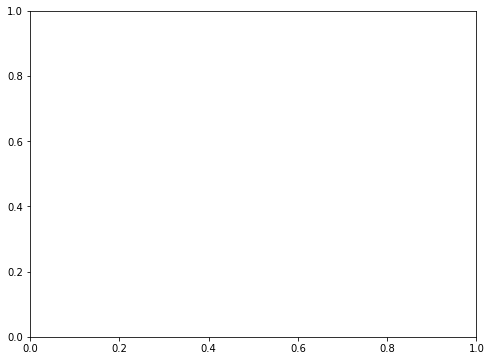

In [19]:
log.plot_epochs(['trn_loss','val_loss'])
#log.plot_epochs(['trn_loss','trn_loss'])

  0%|          | 0/102 [00:00<?, ?it/s]


AttributeError: 'Report' object has no attribute 'trn_loss'

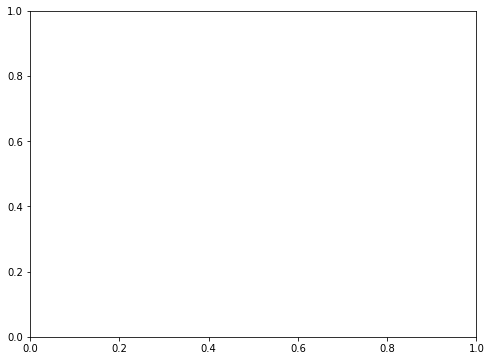

In [20]:
log.plot_epochs(['trn_loss','trn_loss'])

In [19]:
# from torchvision.ops import nms

# def decode_output(output):
#     'convert tensors to numpy arrays'
#     bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
#     labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
#     confs = output['scores'].cpu().detach().numpy()
#     print("---confs-aaa--",confs)

#     ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
#     bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
#     print("---confs-bbb--",confs)

#     if len(ixs) == 1:
#         bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
#     return bbs.tolist(), confs.tolist(), labels.tolist()
# #


In [21]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    print("----INIT---output['boxes']---\n",output['boxes'])
    print("----INIT---output['scores']---\n",output['scores'])
    print("----INIT---output['labels']---\n",output['labels'])

    bbs_original = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ## bbs_original
    ixs = nms(torch.tensor(bbs_original.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs_original, confs, labels = [tensor[ixs] for tensor in [bbs_original, confs, labels]]


    print("--ORIGINAL-type(confs-aaa--",type(confs))
    print("--ORIGINAL-confs-aaa.shape--",confs.shape)
    print("--ORIGINAL-confs-aaa--",confs)
    #
    ls_temp = []
    ls_temp_bbs = []
    ls_temp_labels = []

    for iter_k in range(len(confs)):
        if len(confs) > 0:
            #
            if confs[iter_k] > 0.5:
                print("-----confs[iter_k] -->> 0.5----",confs[iter_k])
                ls_temp.append(confs[iter_k])
                ls_temp = np.array(ls_temp)

                
                #ls_temp.append(confs[iter_k])
                bbs_optimized = output['boxes'].cpu().detach().numpy().astype(np.uint16)
                print("-----bbs_optimized[iter_k] -->> 0.5----",bbs_optimized[iter_k])
                print("--bbs_optimized-type(--",type(bbs_optimized))
                print("--bbs_optimized.shape--",bbs_optimized.shape)
                print("--bbs_optimized-aaa--",bbs_optimized)
                ls_temp_bbs.append(bbs_optimized[iter_k])
                ls_temp_bbs = np.array(ls_temp_bbs)
                        
                #ixs = nms(torch.tensor(bbs_optimized.astype(np.float32)), torch.tensor(confs), 0.05)
                ixs = nms(torch.tensor(ls_temp_bbs.astype(np.float32)), torch.tensor(ls_temp), 0.05)

                print("--ixs-type(--",type(ixs))
                print("--ixs.shape--",ixs.shape)
                print("--ixs-aaa--",ixs)
                print("-----ixs[iter_k] -->> 0.5----",ixs[iter_k])

                ##RuntimeError: boxes and scores should have same number of elements in dimension 0, got 43 and 12
                bbs_optimized, confs, labels = [tensor[ixs] for tensor in [bbs_optimized, confs, labels]]
                
                
                ls_temp_labels.append(labels)
                #print("-------confs -->> 0.5--bbb---",confs)
        
            else:
                pass
        else:
            pass
        
    if len(ixs) == 1:
        bbs_original, confs, labels = [np.array([tensor]) for tensor in [bbs_original, confs, labels]]
    
    confs = ls_temp
    print("-----len(confs",len(confs))
    print("-----len(ls_temp_bbs",len(ls_temp_bbs))
    print("-----len(ls_temp_bbs",ls_temp_bbs)
    #
    print("-----len(bbs_original",len(bbs_original.tolist()))
    print("-----bbs_original",bbs_original.tolist())

    #return bbs_original.tolist(), confs, labels.tolist()
    return ls_temp_bbs, confs, ls_temp_labels# labels.tolist()
#


In [22]:
### FOOBAR --- Do separate EVAL
#  
model_fasterrcnn_resnet50.eval()
print("------here----beyond ---eval() -----------")



------here----beyond ---eval() -----------


----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 67., 105.,  91., 138.]]), 'labels': tensor([1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[202.8443,  27.8363, 224.0000,  52.2172],
        [ 59.5035, 109.8762,  91.2272, 141.9665],
        [ 30.3349,  72.2479, 100.4737, 100.1769],
        [ 12.2706,  58.8691,  24.8308,  69.8918],
        [131.6728,  74.0807, 166.4046,  92.8617],
        [195.6840, 108.8040, 208.4260, 129.7933],
        [ 31.7583,  66.1294,  69.7851, 100.6142],
        [ 90.7155, 114.6053, 115.3171, 134.9266],
        [193.8792, 104.5414, 221.6745, 130.7452],
        [ 40.7540, 114.7718,  65.6883, 136.8521],
        [ 64.9334, 104.8634,  90.5174, 143.3512],
        [ 89.9669,  74.8248, 130.3624,  96.6531],
        [200.5479,  27.1400, 222.8581,  80.5175],
        [  0.0000,  78.7462,  44.9148, 107.9528],
        [ 42.6621,   0.0000,  54.9933,  32.1288],
        [ 66.9702,  98.9484,  92.9105, 125.2207],
        [170.1270, 122.6615, 208.1143, 143.7807],
        [  0.0000,  81.0378,  26.9787, 122.0540],
        [ 90.1865, 112.3332, 138.7964, 135.8789],
        [142.4961,  76

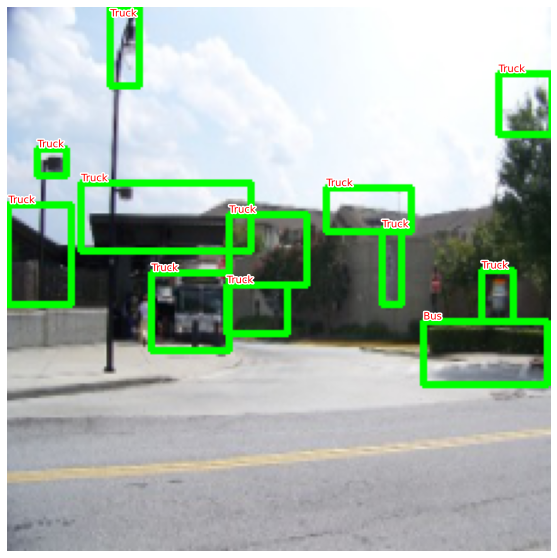

----foobar----len(boxes 2
--------target-- {'boxes': tensor([[150., 114., 159., 124.],
        [185., 177., 223., 204.]]), 'labels': tensor([2, 2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[188.0552, 176.6531, 224.0000, 203.6129],
        [ 71.0086, 187.0986,  96.5412, 219.5415],
        [138.9143, 167.1428, 156.2125, 192.3298],
        [ 12.7916, 195.8692,  45.9024, 222.9463],
        [100.1852, 178.1750, 112.7113, 201.6102],
        [177.1481, 125.4360, 204.9441, 148.8423],
        [143.1129, 104.0090, 172.8170, 128.3741],
        [ 35.9703, 101.4699,  71.8881, 120.1551],
        [156.1206,  83.7850, 189.5124, 106.3548],
        [ 69.3407, 101.1454,  85.8109, 112.3293],
        [165.7056, 163.7357, 224.0000, 207.2366],
        [186.3636, 109.5040, 222.2179, 132.5153],
        [ 10.8934,  79.8934,  54.0776, 116.0367],
        [ 60.4583, 184.1560,  92.0136, 212.4879],
        [ 48.2860, 174.2450,  69.8067, 193.2550],
        [ 27.9466,  78.2881,  55.7361, 103.3463],
        [ 49.3539,  87.5178,  83.5056, 104.7807],
        [136.2228, 149.2728, 158.2274, 193.1998],
        [186.6208, 177.6773, 222.2980, 201.8796],
        [172.8437, 108

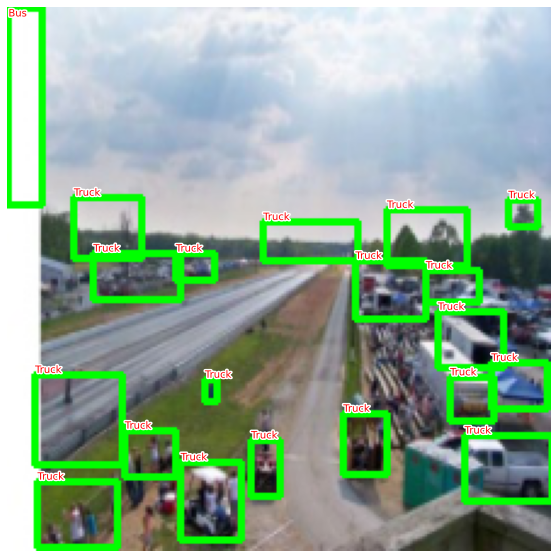

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  78.,  69., 150.]]), 'labels': tensor([1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[1.2784e+02, 8.1718e+01, 1.8020e+02, 1.0954e+02],
        [2.9029e+01, 7.7204e+01, 6.7936e+01, 9.9236e+01],
        [2.9293e+01, 1.0928e+02, 5.5874e+01, 1.2761e+02],
        [1.4262e-01, 9.8873e+01, 3.0667e+01, 1.2775e+02],
        [0.0000e+00, 7.5479e+01, 4.2092e+01, 9.9689e+01],
        [0.0000e+00, 1.2635e+02, 2.9462e+01, 1.5577e+02],
        [9.3560e+01, 9.3374e+01, 1.3173e+02, 1.1866e+02],
        [7.8826e+01, 1.0475e+02, 1.0902e+02, 1.2329e+02],
        [0.0000e+00, 1.9458e+02, 2.5863e+01, 2.2294e+02],
        [1.3065e+01, 1.2410e+01, 3.5397e+01, 2.7887e+01],
        [9.0714e+01, 1.0628e+02, 1.0926e+02, 1.1881e+02],
        [1.1712e+02, 9.6045e+01, 1.3134e+02, 1.1391e+02],
        [8.2277e+01, 0.0000e+00, 1.0942e+02, 1.2351e+01],
        [1.0504e+02, 0.0000e+00, 1.6772e+02, 1.3564e+01],
        [0.0000e+00, 3.7502e+01, 1.0080e+01, 6.7421e+01],
        [9.0031e+01, 1.0115e+02, 1.2070e+02, 1.1939e+02],
        [0.0000e+00, 9.4090e+01, 5.5842e+01,

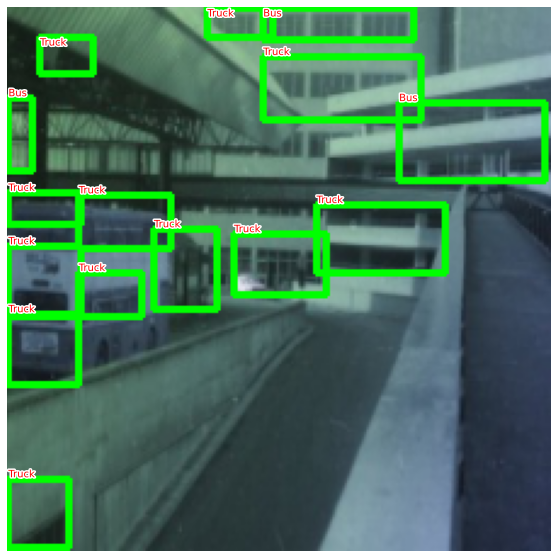

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 36.,  36., 164., 199.]]), 'labels': tensor([2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[  0.4046, 133.0143,  35.8482, 156.6724],
        [ 65.1944, 148.1685,  98.2971, 172.5455],
        [ 31.8315, 176.7334,  56.8521, 221.6545],
        [  0.0000, 110.0286,  46.2464, 158.1680],
        [ 29.1604, 102.7371,  53.0291, 123.6453],
        [ 82.2331,  54.1986, 157.8465,  91.5246],
        [158.0247,  71.9048, 179.0369,  98.2581],
        [ 79.2424,  80.2814, 114.6233, 109.1594],
        [142.5113, 173.9853, 164.6656, 224.0000],
        [109.3332, 175.7271, 141.8121, 213.4855],
        [ 64.9442,  38.9337, 114.8343,  73.3529],
        [191.3452,  60.6503, 210.0909,  94.0117],
        [  1.1471, 124.2750,  36.4305, 156.6960],
        [164.6159, 200.1766, 195.8385, 221.5809],
        [ 49.4884, 112.0175,  68.2330, 180.3256],
        [  0.0000,  82.8989,  21.3678, 103.3167],
        [102.5276,  29.0750, 134.3286,  44.8519],
        [ 32.4171,  68.5289,  55.9362,  86.4113],
        [144.6409, 144.1738, 169.4579, 185.9768],
        [ 73.5221, 168

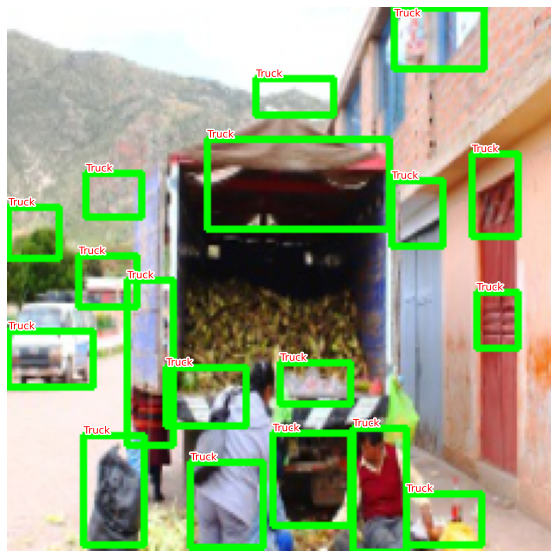

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 75.,  60., 161., 186.]]), 'labels': tensor([2])}
-----outputs---- 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[153.3707,  63.9927, 196.1444,  87.3227],
        [124.4897, 147.8681, 149.9266, 183.2979],
        [  0.8741, 130.5073,  26.6339, 172.3610],
        [102.4310,  12.8195, 142.9224,  54.6192],
        [ 88.6671,  60.6171, 146.1701,  92.7476],
        [188.2855,  47.8561, 209.8530,  67.6027],
        [151.7248,  50.2843, 187.9094,  84.8816],
        [105.0064,   8.1877, 143.2883,  34.6260],
        [ 61.1005,   0.0000,  90.6133,  23.9917],
        [105.1963,  56.0273, 130.7676,  71.9003],
        [ 94.4965, 116.7492, 140.3961, 143.5272],
        [124.1326,  56.2826, 145.7075,  72.3012],
        [ 74.8334, 146.4063, 126.7282, 182.0015],
        [ 91.9379,  87.7746, 129.7100, 118.3629],
        [ 39.0538,  42.4792,  67.4940,  70.5434],
        [193.8236, 114.3248, 219.6523, 133.1257],
        [161.1311,   0.0000, 180.2088,  16.7681],
        [124.7391, 148.2428, 149.2617, 183.7966],
        [ 88.7747,  59.1333, 144.7365,  93.1097],
        [159.1519,  96.8893, 185.0070, 

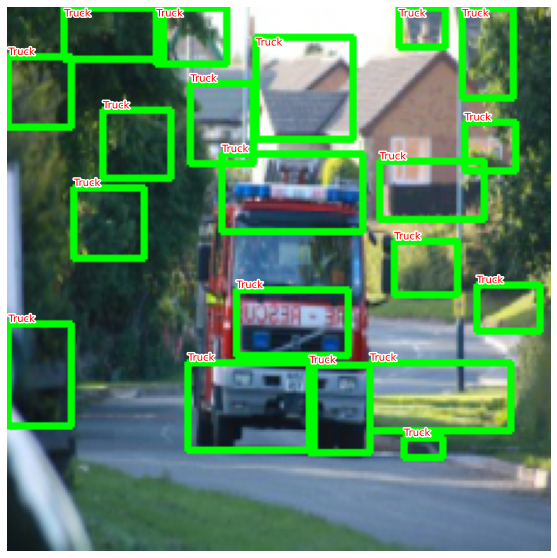

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,  36., 203.,  96.]]), 'labels': tensor([1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[1.3477e+02, 5.4162e+01, 1.6075e+02, 9.4310e+01],
        [1.0732e+02, 6.8307e+01, 1.3187e+02, 9.0704e+01],
        [1.3415e+02, 8.9428e+01, 1.7440e+02, 1.1550e+02],
        [1.3964e+02, 3.7368e+01, 1.6967e+02, 5.4782e+01],
        [1.2464e+01, 5.7053e+01, 7.1331e+01, 8.7077e+01],
        [1.8359e+02, 0.0000e+00, 2.2203e+02, 2.0627e+01],
        [5.9900e+01, 1.7980e+02, 8.6806e+01, 1.9759e+02],
        [1.0943e+02, 6.0029e+01, 1.2690e+02, 7.6751e+01],
        [1.6609e+02, 9.4047e+01, 1.8056e+02, 1.1420e+02],
        [1.2352e+01, 5.7085e+01, 4.4105e+01, 8.6250e+01],
        [7.8468e+01, 1.5794e+01, 1.0401e+02, 3.9724e+01],
        [1.2457e+02, 5.0868e+00, 1.7080e+02, 3.1511e+01],
        [1.3562e+02, 7.3014e+01, 1.6183e+02, 9.4004e+01],
        [0.0000e+00, 3.7794e-01, 5.2197e+01, 2.8926e+01],
        [3.9229e+01, 5.6275e+01, 8.9968e+01, 8.7274e+01],
        [4.3933e+01, 2.5928e+01, 7.5412e+01, 5.3166e+01],
        [1.2826e+02, 3.7452e+00, 1.6792e+02,

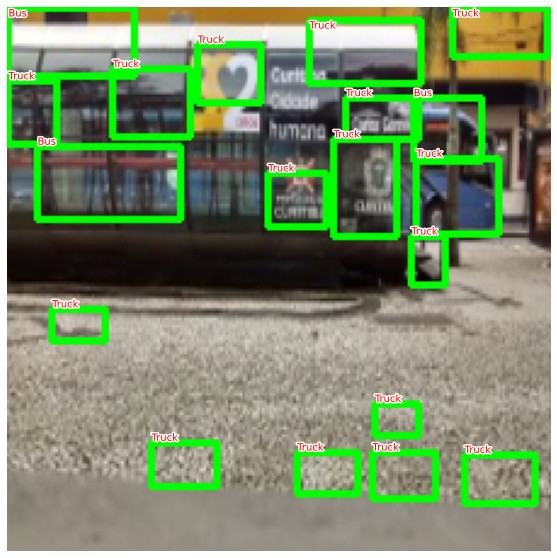

----foobar----len(boxes 2
--------target-- {'boxes': tensor([[  0.,   0., 200., 223.],
        [199.,  83., 218., 164.]]), 'labels': tensor([1, 1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[1.4966e+02, 1.9843e+02, 1.9296e+02, 2.2326e+02],
        [5.5987e-01, 1.9845e+02, 3.2527e+01, 2.2396e+02],
        [1.9319e+02, 4.2684e+01, 2.1660e+02, 6.3685e+01],
        [3.4393e+01, 1.9179e+02, 8.7367e+01, 2.2324e+02],
        [0.0000e+00, 3.2631e+01, 2.4603e+01, 5.8549e+01],
        [1.3965e+02, 1.0354e+02, 1.5466e+02, 1.3839e+02],
        [5.5798e+01, 1.4336e+02, 8.3968e+01, 1.7712e+02],
        [1.1333e+02, 2.2606e+01, 1.3636e+02, 6.0997e+01],
        [0.0000e+00, 1.4862e+02, 3.9386e+01, 1.9610e+02],
        [2.0109e+02, 1.6968e+02, 2.1695e+02, 1.8113e+02],
        [2.0007e+02, 1.0425e+01, 2.1759e+02, 2.6692e+01],
        [2.0057e+02, 0.0000e+00, 2.2355e+02, 1.4742e+01],
        [0.0000e+00, 1.1784e+02, 4.4059e+01, 2.0642e+02],
        [1.6799e+02, 3.9532e+01, 1.9805e+02, 6.7122e+01],
        [1.6891e-01, 5.9084e+01, 3.8886e+01, 9.7391e+01],
        [1.3268e+02, 0.0000e+00, 1.5512e+02, 3.8536e+01],
        [1.9757e+02, 1.2650e+02, 2.2217e+02,

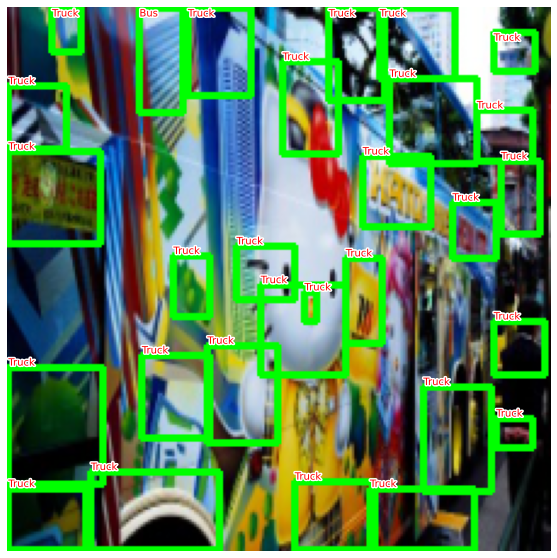

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 67.,  83., 208., 204.]]), 'labels': tensor([2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[1.6630e+02, 3.3873e+01, 1.8248e+02, 7.5527e+01],
        [6.6732e+01, 1.0363e+02, 2.1846e+02, 1.9930e+02],
        [1.6470e+02, 0.0000e+00, 1.8238e+02, 2.8660e+01],
        [7.4444e+01, 4.1378e+01, 9.1685e+01, 7.3723e+01],
        [1.4900e+02, 9.3177e+01, 1.8543e+02, 1.2150e+02],
        [1.1951e+02, 3.5613e+01, 1.3468e+02, 7.4712e+01],
        [3.5323e+01, 1.3420e+02, 6.6881e+01, 1.5803e+02],
        [7.6218e+01, 4.2490e+01, 9.1342e+01, 7.3747e+01],
        [7.6181e+01, 6.1847e+00, 9.3771e+01, 3.2872e+01],
        [1.1952e+02, 3.9535e-01, 1.3491e+02, 3.2781e+01],
        [1.6461e+02, 0.0000e+00, 1.8271e+02, 2.9353e+01],
        [1.1832e+02, 3.4081e+01, 1.3508e+02, 7.3816e+01],
        [1.6507e+02, 3.3000e+01, 1.8311e+02, 7.4636e+01],
        [9.7873e+01, 1.0095e+02, 1.3727e+02, 1.3200e+02],
        [2.1212e+02, 0.0000e+00, 2.2394e+02, 1.6194e+01],
        [0.0000e+00, 1.2331e+02, 2.4347e+01, 1.7424e+02],
        [7.6505e+01, 8.1889e+01, 1.0193e+02,

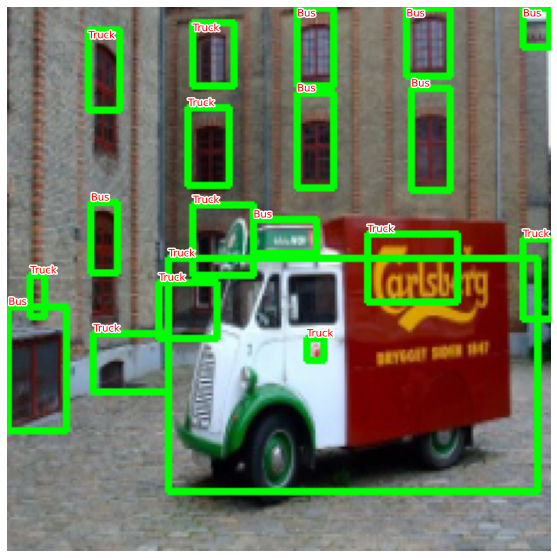

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 26., 122., 203., 223.]]), 'labels': tensor([2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[ 55.9577, 190.2667,  95.3395, 222.9174],
        [181.1341,  27.0731, 209.7647,  48.1662],
        [117.9278, 200.1646, 173.3645, 223.5096],
        [ 46.2075,   0.0000,  95.7956,  26.1348],
        [160.4276, 152.9153, 201.8770, 185.0674],
        [  0.0000,   0.0000,  28.2421,  20.0576],
        [196.0871, 122.4640, 222.7491, 187.7824],
        [ 24.6058, 168.1766,  52.5239, 207.3245],
        [ 98.5715,  77.4916, 117.8747,  94.5883],
        [ 84.0040,  89.9983, 120.1738, 118.4222],
        [ 23.6268, 173.0132,  91.7537, 207.1030],
        [116.5469, 208.5446, 144.2136, 223.6841],
        [199.9801, 131.2679, 223.0656, 189.1218],
        [ 20.8338, 133.0490,  46.3598, 154.0443],
        [178.0993, 151.0161, 202.4649, 192.2230],
        [164.4289, 175.8744, 189.7555, 207.8074],
        [ 62.3464, 188.3609,  92.3704, 211.9209],
        [ 31.8941, 107.9984, 208.3627, 221.1158],
        [ 26.5601,   0.0000, 127.3168,  23.2796],
        [141.4993,  93

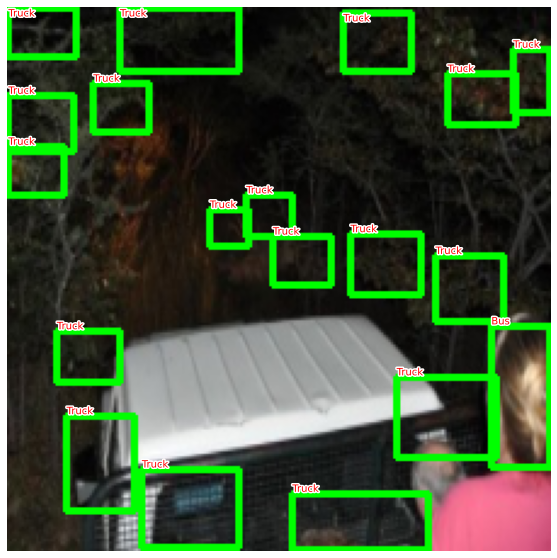

----foobar----len(boxes 4
--------target-- {'boxes': tensor([[  0.,  71.,  28., 138.],
        [ 28.,  81.,  60., 122.],
        [ 54.,  76.,  83., 115.],
        [ 80.,  82., 113., 106.]]), 'labels': tensor([1, 1, 1, 1])}
-----outputs---- 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[0.0000e+00, 1.1313e+02, 2.8117e+01, 1.4192e+02],
        [1.8054e+02, 1.2402e+02, 2.1022e+02, 1.4434e+02],
        [1.5612e+02, 8.7765e+01, 1.8729e+02, 1.1420e+02],
        [1.4059e+02, 5.5562e+01, 1.7974e+02, 7.5660e+01],
        [1.9317e+02, 7.5013e+01, 2.2400e+02, 9.1917e+01],
        [1.0985e-01, 7.0123e+01, 3.0079e+01, 8.6732e+01],
        [7.9875e+01, 7.7461e+01, 1.1070e+02, 1.0727e+02],
        [9.3984e+00, 7.9213e+01, 3.0309e+01, 9.5411e+01],
        [8.1679e+01, 7.8489e+01, 1.0991e+02, 1.0876e+02],
        [1.5401e+02, 1.8367e+02, 1.7553e+02, 1.9574e+02],
        [2.7364e+01, 6.5584e+01, 6.3809e+01, 9.8947e+01],
        [6.2012e+01, 4.6257e+01, 1.3190e+02, 7.4926e+01],
        [8.6142e+01, 1.0454e+02, 1.1664e+02, 1.3224e+02],
        [2.8640e+01, 9.5251e+01, 6.3688e+01, 1.2438e+02],
        [1.2990e+02, 5.1182e+01, 1.7275e+02, 7.1645e+01],
        [6.3462e+01, 4.7666e+01, 1.0031e+02, 7.6124e+01],
        [1.7928e+02, 1.3801e+02, 2.0831e+02, 1.6793e+02],
   

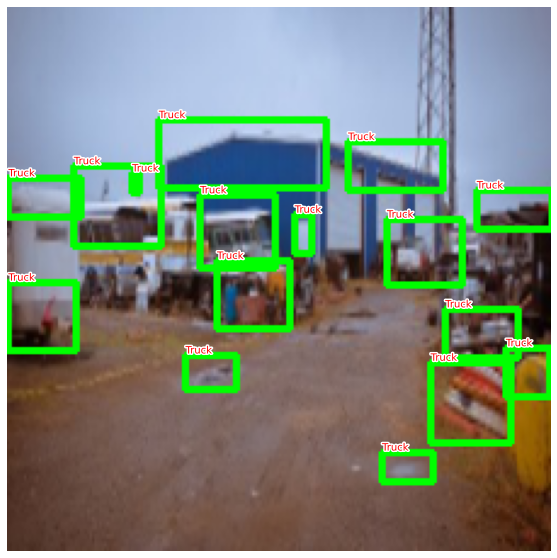

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  0.,   0., 104., 212.]]), 'labels': tensor([1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[0.0000e+00, 9.5568e+01, 2.1978e+01, 1.2594e+02],
        [1.7468e+02, 9.9100e+01, 2.0709e+02, 1.2814e+02],
        [1.2145e+01, 1.5941e+02, 3.5654e+01, 1.9769e+02],
        [0.0000e+00, 9.8081e+01, 2.1492e+01, 1.2253e+02],
        [5.5926e+01, 4.2422e+01, 7.7706e+01, 8.0584e+01],
        [1.9270e+02, 1.4196e+02, 2.2248e+02, 1.6664e+02],
        [7.5613e+01, 6.5399e+01, 1.0039e+02, 9.0501e+01],
        [0.0000e+00, 4.8082e-01, 5.0586e+01, 4.1434e+01],
        [5.5334e+01, 1.0501e+02, 7.9244e+01, 1.2213e+02],
        [1.7840e+02, 5.8530e+01, 2.2377e+02, 1.2775e+02],
        [2.0785e+01, 9.7196e+01, 6.1429e+01, 1.2131e+02],
        [5.8419e+01, 5.9927e+01, 7.8509e+01, 8.0772e+01],
        [2.1158e-01, 1.0668e+00, 3.5920e+01, 3.4288e+01],
        [1.1142e+01, 1.9805e+02, 3.2894e+01, 2.1936e+02],
        [3.0387e+01, 1.7843e+02, 6.7864e+01, 2.2239e+02],
        [1.8571e+02, 6.6778e+01, 2.2309e+02, 1.0692e+02],
        [1.8265e+02, 1.1626e+02, 2.2197e+02,

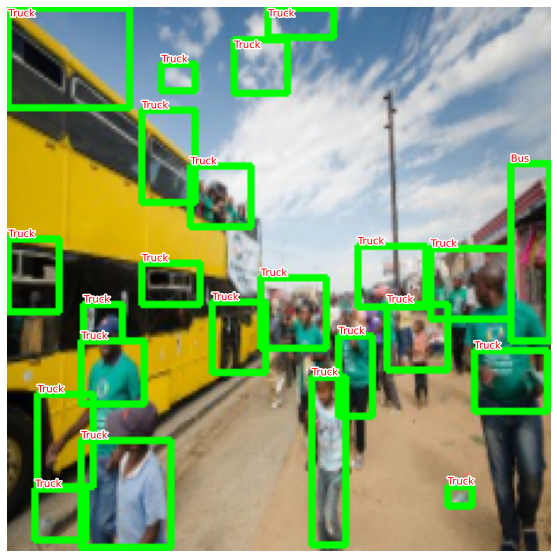

----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0., 105.,  20., 144.],
        [ 34., 108.,  59., 134.],
        [ 60.,  92., 159., 175.]]), 'labels': tensor([1, 1, 1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[  0.0000,  98.8048,  21.4271, 149.2122],
        [ 32.4516, 103.0748,  59.6341, 137.9306],
        [105.8119,  91.7760, 148.0462, 131.6771],
        [ 56.8470,  90.4814, 116.1723, 122.0445],
        [185.7212, 127.9038, 223.7594, 155.7401],
        [ 34.1346, 105.9099,  59.5918, 135.9400],
        [ 88.9976, 124.0512, 156.0027, 179.6084],
        [  0.0000, 102.0611,  20.1470, 128.3051],
        [ 86.9579, 131.4516, 157.7726, 178.2408],
        [170.0081, 122.5056, 195.5494, 144.5937],
        [  0.0000, 101.4822,  20.6966, 122.4460],
        [  0.0000, 113.5309,  21.5073, 147.1992],
        [  0.0000,  82.7078,   8.5751, 104.8341],
        [ 96.2151, 125.2706, 133.5467, 154.7437],
        [156.9868, 133.7807, 170.1627, 157.1323],
        [  0.0000,  88.3455,  20.1409, 137.1417],
        [190.8695,  31.7987, 214.6333,  56.0800],
        [  0.0000,  83.4136,   8.3878, 104.9517],
        [ 66.0447, 137.3059,  98.9501, 166.2516],
        [  2.7586,  93

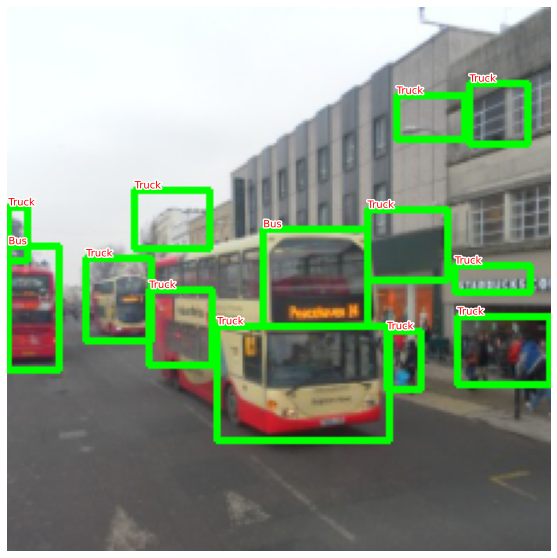

----foobar----len(boxes 2
--------target-- {'boxes': tensor([[ 38.,   0., 223., 204.],
        [ 39.,   0., 223., 204.]]), 'labels': tensor([1, 2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[6.6680e+01, 8.4254e+01, 2.2400e+02, 1.9114e+02],
        [6.2527e-01, 1.9082e+01, 1.4385e+01, 4.1903e+01],
        [3.3419e+00, 6.9976e+01, 4.1230e+01, 9.5355e+01],
        [7.7276e+01, 8.7966e+01, 1.2784e+02, 1.1713e+02],
        [1.7482e+02, 0.0000e+00, 2.0077e+02, 2.7134e+01],
        [7.5136e+01, 2.3937e+01, 1.1690e+02, 3.9896e+01],
        [1.3393e+02, 6.4497e+01, 1.6282e+02, 9.3615e+01],
        [1.7039e+02, 8.3529e+01, 2.2400e+02, 1.9502e+02],
        [2.0908e+02, 1.5900e+01, 2.2300e+02, 3.6497e+01],
        [1.1561e+02, 4.4978e+01, 1.2670e+02, 6.8679e+01],
        [1.5887e-02, 5.4629e+01, 1.1369e+01, 7.9262e+01],
        [1.5162e+02, 0.0000e+00, 1.9819e+02, 2.8062e+01],
        [5.2146e+01, 1.0391e+02, 8.1982e+01, 1.2844e+02],
        [6.3570e+00, 4.6616e+01, 4.1357e+01, 7.7269e+01],
        [0.0000e+00, 5.5662e+01, 1.5605e+01, 7.7708e+01],
        [3.7247e+01, 1.5320e+02, 6.2211e+01, 1.9488e+02],
        [3.6371e+01, 8.1569e+00, 9.9817e+01,

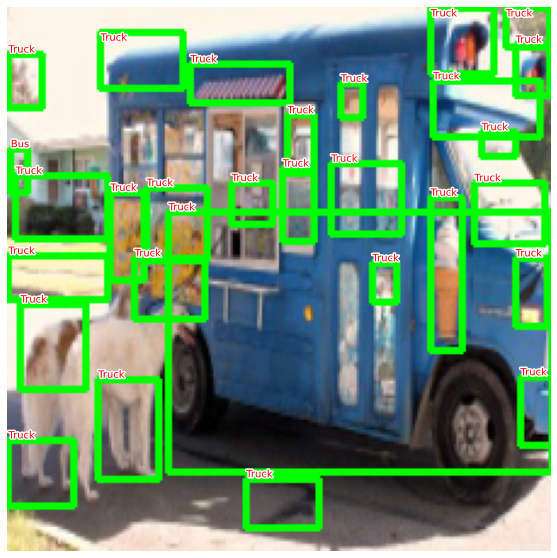

----foobar----len(boxes 3
--------target-- {'boxes': tensor([[  0.,  67., 143., 160.],
        [142.,  95., 172., 131.],
        [171.,  96., 214., 127.]]), 'labels': tensor([1, 1, 1])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[107.2144, 195.9530, 140.7942, 216.8372],
        [ 69.3722, 192.4225, 105.2746, 211.1061],
        [171.9647,  95.5337, 213.2244, 130.4959],
        [ 47.6616, 106.2402,  87.5194, 122.1074],
        [ 38.3422, 190.3654,  75.1574, 207.3102],
        [140.9724,  89.0315, 174.7173, 115.0242],
        [150.8098, 199.4807, 183.0732, 216.3756],
        [ 19.3911, 104.1465,  46.4544, 118.4700],
        [ 82.4875, 107.6473, 113.3750, 123.3676],
        [146.2100,  90.1686, 217.6817, 132.9014],
        [107.2989, 119.0248, 143.5762, 145.5172],
        [  0.0000, 129.5086,  32.8973, 167.5459],
        [  6.6966, 185.6727,  44.6176, 204.8448],
        [140.0180, 112.5155, 172.5564, 134.6706],
        [ 94.4051,  80.9979, 143.2521, 108.2788],
        [173.3668,  96.5444, 213.2336, 127.1666],
        [  0.0000,  76.1286, 156.8719, 164.5818],
        [  0.0000,  66.3304,  64.3018,  97.0311],
        [  0.0000, 105.2615,  28.1469, 146.6680],
        [  3.3487,  75

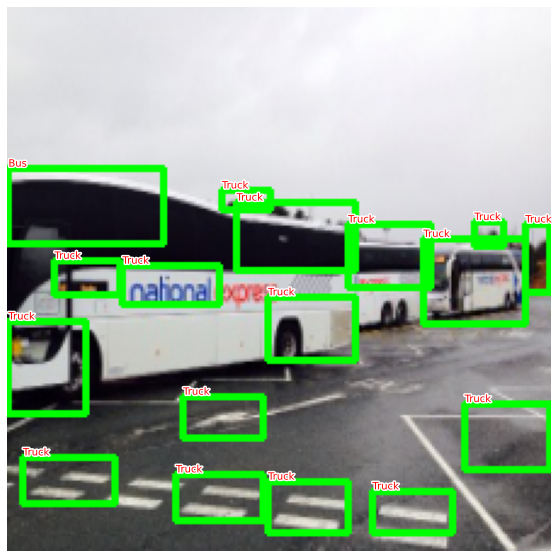

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[  1.,  72.,  33., 134.]]), 'labels': tensor([2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----outputs---- [{'boxes': tensor([[6.0111e-01, 1.8557e+02, 3.7824e+01, 1.9906e+02],
        [1.9143e+02, 1.0809e+02, 2.2249e+02, 1.3526e+02],
        [5.6180e+01, 3.3570e+01, 9.7280e+01, 5.9001e+01],
        [2.2333e-01, 6.9709e+01, 3.0777e+01, 1.0372e+02],
        [1.7099e+02, 7.1996e+01, 1.9718e+02, 9.2293e+01],
        [1.5159e+02, 9.6434e+01, 1.6972e+02, 1.4243e+02],
        [2.8373e+00, 1.0581e+02, 3.4657e+01, 1.3266e+02],
        [1.9825e+02, 7.1315e+01, 2.2268e+02, 9.2315e+01],
        [5.5461e+01, 1.1873e+02, 9.5902e+01, 1.4833e+02],
        [0.0000e+00, 7.1393e+01, 3.7489e+01, 1.4040e+02],
        [2.9605e+01, 3.2843e+01, 5.8943e+01, 6.4298e+01],
        [2.8078e+01, 1.1653e+02, 6.6867e+01, 1.4628e+02],
        [1.9880e+02, 0.0000e+00, 2.2349e+02, 3.3733e+01],
        [2.0071e+02, 3.9207e+01, 2.1734e+02, 6.7902e+01],
        [1.7250e+02, 8.5390e+01, 1.9780e+02, 1.2291e+02],
        [5.5510e+01, 3.6544e+01, 8.9340e+01, 6.3267e+01],
        [1.9753e+02, 0.0000e+00, 2.2332e+02,

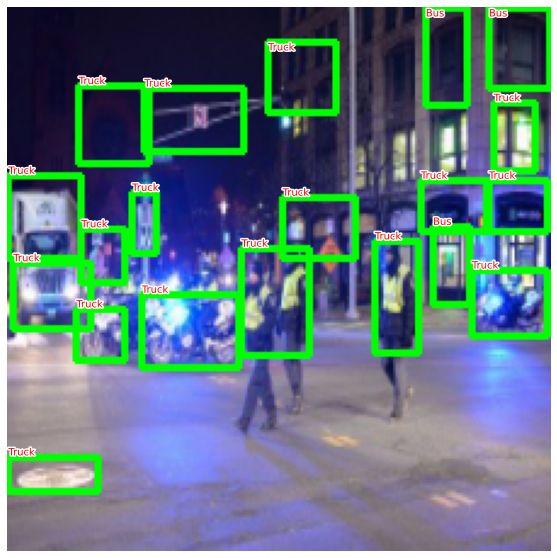

----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 42.,  56., 199., 143.]]), 'labels': tensor([2])}


In [18]:
# for ix, (images, targets) in enumerate(test_loader):

#     if ix==15: break
#     images = [im for im in images]
#     outputs = model_fasterrcnn_resnet50(images)
#     print("-----outputs----",outputs)
#     for ix, output in enumerate(outputs):
#         bbs, confs, labels = decode_output(output)
#         info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
#         print("-----info----",info)
#         show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=10)


In [23]:
### Jupyter Code - OK 
for ix, (images, targets) in enumerate(test_loader):

    if ix==15: break ## get 15 Images 
    images = [im for im in images]
    outputs = model_fasterrcnn_resnet50(images)
    #print("-----outputs----",outputs)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print("---confs[1]----",confs[1])
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        print("-----info----",info)
        for iter_k in range(len(confs)):
            if confs[iter_k] > 0.5:
                print("-------confs[iter_k] > 0.5----",confs[iter_k])
                #bbs, confs, labels = decode_output(output)
                show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=10)
            else:
                print("---Low Confidence ---",confs[iter_k])


----foobar----len(boxes 1
--------target-- {'boxes': tensor([[ 67., 105.,  91., 138.]]), 'labels': tensor([1])}
----INIT---output['boxes']---
 tensor([[ 66.7003, 111.6483,  92.1792, 139.2054],
        [ 38.6327,  79.5107, 133.1054, 141.1370],
        [ 66.2019, 112.2435,  92.1541, 141.5175],
        [  8.5022,  81.5755,  96.9958, 140.5142],
        [ 20.9809,  75.2556, 178.7187, 160.2029],
        [ 84.5017,  77.9760, 132.9391, 135.7428]], device='cuda:0',
       grad_fn=<StackBackward0>)
----INIT---output['scores']---
 tensor([0.8533, 0.3075, 0.2058, 0.0937, 0.0872, 0.0727], device='cuda:0',
       grad_fn=<IndexBackward0>)
----INIT---output['labels']---
 tensor([1, 1, 2, 1, 1, 1], device='cuda:0')
--ORIGINAL-type(confs-aaa-- <class 'numpy.float32'>
--ORIGINAL-confs-aaa.shape-- ()
--ORIGINAL-confs-aaa-- 0.8533356


TypeError: object of type 'numpy.float32' has no len()